In [98]:
import pandas as pd
import numpy as np
train = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
train = train[(train['Recidivism_Arrest_Year1']==False) & (train['Recidivism_Arrest_Year2']==False)]
test = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Test_Dataset3.csv')
train  = pd.concat([train[test.columns], train['Recidivism_Arrest_Year3']], axis =1)
train = pd.concat([train,test]).reset_index(drop=True)


for i in train.columns:
    if train[i].dtypes == 'object':
        train[i] = train[i].astype(str).str.replace(' or more', '').replace('nan', np.nan)


int_variables = ['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',\
'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Felony',\
'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Delinquency_Reports',\
                'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 'Dependents']
for i in int_variables:
    train[i] = train[i].astype('int')
    
bool_variables = [i for i in train.columns if train[i].dtypes == 'bool']


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
nan_variables = ['Gang_Affiliated', 'Supervision_Risk_Score_First', 'Supervision_Level_First', 'Prison_Offense', \
                 'Recidivism_Arrest_Year3', 'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive','DrugTests_Cocaine_Positive', \
                 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_var = ['Gender', 'Race']


one_hot_variables = ['Age_at_Release','Residence_PUMA', 'Education_Level' , 'Prison_Years']

In [99]:

import seaborn as sns
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [100]:
train['Residence_PUMA'] = train['Residence_PUMA'].astype('str')

In [101]:
dummies = pd.get_dummies(train[one_hot_variables])

In [102]:
train = train.drop(one_hot_variables, axis = 1)
train = pd.concat([train,dummies], axis=1)

In [103]:
for i in cat_var + bool_variables:
    train[i] = labelencoder.fit_transform(train[i])

for i in nan_variables:
    train[nan_variables] = train[nan_variables].replace('nan', np.nan)

original = train[nan_variables]
mask = train[nan_variables].isnull()

for i in nan_variables:
    if train[i].dtypes == 'object':
        train[i] = labelencoder.fit_transform(train[i].astype('str'))

train[nan_variables] = train[nan_variables].where(~mask, original)

train[nan_variables] = train[nan_variables].astype('float')

train['Recidivism_Arrest_Year3'] = train['Recidivism_Arrest_Year3'].astype('float')

In [104]:
train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
test_df = train[train['Recidivism_Arrest_Year3'].isnull()]
feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]

X = train_df[feats]
X = X.fillna(-1)
y  = train_df['Recidivism_Arrest_Year3']

In [105]:
from sklearn.metrics import roc_auc_score

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from IPython.display import display
from sklearn.model_selection import train_test_split

In [106]:
def objective(trial, data = X, target = y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'booster': 'gbtree',
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'n_estimators': 4000

    }
    
    model = XGBClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 500, verbose = 200)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

In [107]:
%%time
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-06-29 23:26:52,627] A new study created in memory with name: no-name-6ddd9a36-e31b-42c6-9872-22cbaa282f3d


[23:26:52] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.53962
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62255
[400]	validation_0-auc:0.62255
[600]	validation_0-auc:0.62458
[800]	validation_0-auc:0.62522
[1000]	validation_0-auc:0.62583
[1200]	validation_0-auc:0.62583
[1400]	validation_0-auc:0.62650
[1600]	validation_0-auc:0.62630
Stopping. Best iteration:
[1217]	validation_0-auc:0.62660



[I 2021-06-29 23:27:01,355] Trial 0 finished with value: 0.6265986333770395 and parameters: {'max_depth': 10, 'learning_rate': 0.08, 'min_child_weight': 231, 'gamma': 0.05570147203171178, 'alpha': 0.0029178375923846122, 'lambda': 0.0006315934994924361, 'colsample_bytree': 0.34501315097995033, 'subsample': 0.389591770221578}. Best is trial 0 with value: 0.6265986333770395.


[23:27:01] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59214
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67421
[400]	validation_0-auc:0.67393
[600]	validation_0-auc:0.67111
Stopping. Best iteration:
[211]	validation_0-auc:0.67474



[I 2021-06-29 23:27:06,275] Trial 1 finished with value: 0.6747368056328062 and parameters: {'max_depth': 6, 'learning_rate': 0.02, 'min_child_weight': 15, 'gamma': 0.0005824708676879594, 'alpha': 0.0008583716152580769, 'lambda': 8.343277192075403, 'colsample_bytree': 0.7133737335086477, 'subsample': 0.45360326868679746}. Best is trial 1 with value: 0.6747368056328062.


[23:27:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62221
[400]	validation_0-auc:0.62406
[600]	validation_0-auc:0.62857
[800]	validation_0-auc:0.63109
[1000]	validation_0-auc:0.63289
[1200]	validation_0-auc:0.63449
[1400]	validation_0-auc:0.63595
[1600]	validation_0-auc:0.63689
[1800]	validation_0-auc:0.63753
[2000]	validation_0-auc:0.63824
[2200]	validation_0-auc:0.63849
[2400]	validation_0-auc:0.63862
[2600]	validation_0-auc:0.63938
[2800]	validation_0-auc:0.63909
[3000]	validation_0-auc:0.63914
Stopping. Best iteration:
[2615]	validation_0-auc:0.63943



[I 2021-06-29 23:27:21,987] Trial 2 finished with value: 0.6394259964731134 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 225, 'gamma': 0.00016994374588488373, 'alpha': 0.8608556202714243, 'lambda': 0.18700023411801955, 'colsample_bytree': 0.39423750365814625, 'subsample': 0.4875044925620633}. Best is trial 1 with value: 0.6747368056328062.


[23:27:22] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.50000
[400]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000



[I 2021-06-29 23:27:24,383] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 170, 'gamma': 0.012055294344379804, 'alpha': 0.5786653819640512, 'lambda': 0.0026854576582023594, 'colsample_bytree': 0.14066708794287788, 'subsample': 0.15785201373512742}. Best is trial 1 with value: 0.6747368056328062.


[23:27:24] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.50000
[400]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000



[I 2021-06-29 23:27:26,793] Trial 4 finished with value: 0.5 and parameters: {'max_depth': 8, 'learning_rate': 0.02, 'min_child_weight': 217, 'gamma': 0.0018658540918888645, 'alpha': 0.0008109176089609264, 'lambda': 0.018626912061331657, 'colsample_bytree': 0.7765223819931958, 'subsample': 0.19807643826762308}. Best is trial 1 with value: 0.6747368056328062.


[23:27:26] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54981
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62760
[400]	validation_0-auc:0.62760
[600]	validation_0-auc:0.62752
[800]	validation_0-auc:0.62837
[1000]	validation_0-auc:0.62838
[1200]	validation_0-auc:0.62876
[1400]	validation_0-auc:0.62920
[1600]	validation_0-auc:0.62919
[1800]	validation_0-auc:0.62957
[2000]	validation_0-auc:0.62973
[2200]	validation_0-auc:0.62972
[2400]	validation_0-auc:0.63002
[2600]	validation_0-auc:0.62966
[2800]	validation_0-auc:0.62952
Stopping. Best iteration:
[2393]	validation_0-auc:0.63002



[I 2021-06-29 23:27:42,572] Trial 5 finished with value: 0.6300233970811092 and parameters: {'max_depth': 8, 'learning_rate': 0.02, 'min_child_weight': 123, 'gamma': 0.2516550453808144, 'alpha': 0.024711143930847234, 'lambda': 0.4271796508046206, 'colsample_bytree': 0.7437164251954264, 'subsample': 0.20443430560027906}. Best is trial 1 with value: 0.6747368056328062.


[23:27:42] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.64848
[400]	validation_0-auc:0.64998
[600]	validation_0-auc:0.64639
Stopping. Best iteration:
[172]	validation_0-auc:0.65014



[I 2021-06-29 23:27:46,316] Trial 6 finished with value: 0.6501452515596534 and parameters: {'max_depth': 9, 'learning_rate': 0.1, 'min_child_weight': 218, 'gamma': 0.19503258044379734, 'alpha': 0.08424244466997242, 'lambda': 3.1642377578290466, 'colsample_bytree': 0.6348552430820187, 'subsample': 0.6151605980429922}. Best is trial 1 with value: 0.6747368056328062.


[23:27:46] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56505
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.63864
[400]	validation_0-auc:0.64049
[600]	validation_0-auc:0.64573
[800]	validation_0-auc:0.64751
[1000]	validation_0-auc:0.64879
[1200]	validation_0-auc:0.64996
[1400]	validation_0-auc:0.65151
[1600]	validation_0-auc:0.65248
[1800]	validation_0-auc:0.65321
[2000]	validation_0-auc:0.65374
[2200]	validation_0-auc:0.65391
[2400]	validation_0-auc:0.65382
[2600]	validation_0-auc:0.65470
[2800]	validation_0-auc:0.65520
[3000]	validation_0-auc:0.65565
[3200]	validation_0-auc:0.65599
[3400]	validation_0-auc:0.65572
[3600]	validation_0-auc:0.656

[I 2021-06-29 23:28:09,176] Trial 7 finished with value: 0.6567358245237153 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 49, 'gamma': 0.26225346858050785, 'alpha': 0.0002923733603879645, 'lambda': 0.4828016315306733, 'colsample_bytree': 0.3838843030851957, 'subsample': 0.19731721819102183}. Best is trial 1 with value: 0.6747368056328062.


[23:28:09] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.50000
[400]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000



[I 2021-06-29 23:28:11,945] Trial 8 finished with value: 0.5 and parameters: {'max_depth': 4, 'learning_rate': 0.08, 'min_child_weight': 254, 'gamma': 0.406216588632096, 'alpha': 0.5982424518588879, 'lambda': 0.0006284543646474808, 'colsample_bytree': 0.29931470446318253, 'subsample': 0.17237573596361538}. Best is trial 1 with value: 0.6747368056328062.


[23:28:11] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.50000
[400]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000



[I 2021-06-29 23:28:14,763] Trial 9 finished with value: 0.5 and parameters: {'max_depth': 5, 'learning_rate': 0.005, 'min_child_weight': 216, 'gamma': 0.007617001375020798, 'alpha': 1.7220068046401529, 'lambda': 0.08664140852649009, 'colsample_bytree': 0.7410468997569281, 'subsample': 0.1036876340203811}. Best is trial 1 with value: 0.6747368056328062.


[23:28:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59473
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67494
[400]	validation_0-auc:0.66905
Stopping. Best iteration:
[97]	validation_0-auc:0.67773



[I 2021-06-29 23:28:19,083] Trial 10 finished with value: 0.6777348415910015 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0.00010548449534585058, 'alpha': 0.007214087751533122, 'lambda': 6.70369318369209, 'colsample_bytree': 0.5657839346203648, 'subsample': 0.771972519960813}. Best is trial 10 with value: 0.6777348415910015.


[23:28:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59491
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67711
[400]	validation_0-auc:0.67198
[600]	validation_0-auc:0.67029
Stopping. Best iteration:
[182]	validation_0-auc:0.67766



[I 2021-06-29 23:28:23,959] Trial 11 finished with value: 0.6776546021857942 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 5, 'gamma': 0.00016129402226285676, 'alpha': 0.00893859741090833, 'lambda': 7.596590698208618, 'colsample_bytree': 0.5498910407202704, 'subsample': 0.7960865802447219}. Best is trial 10 with value: 0.6777348415910015.


[23:28:24] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59859
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68172
[400]	validation_0-auc:0.67891
[600]	validation_0-auc:0.67491
Stopping. Best iteration:
[190]	validation_0-auc:0.68260



[I 2021-06-29 23:28:28,761] Trial 12 finished with value: 0.6826002673431093 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 70, 'gamma': 0.00010225786784530715, 'alpha': 0.011274415891903916, 'lambda': 3.139669018160809, 'colsample_bytree': 0.5554648007510489, 'subsample': 0.7995113795542419}. Best is trial 12 with value: 0.6826002673431093.


[23:28:28] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60170
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67951
[400]	validation_0-auc:0.67865
[600]	validation_0-auc:0.67549
Stopping. Best iteration:
[208]	validation_0-auc:0.68083



[I 2021-06-29 23:28:33,818] Trial 13 finished with value: 0.6808277059371688 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 92, 'gamma': 0.0005330873823709625, 'alpha': 0.08410450620818308, 'lambda': 1.7180491246902039, 'colsample_bytree': 0.52330591450728, 'subsample': 0.789073304603115}. Best is trial 12 with value: 0.6826002673431093.


[23:28:33] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59959
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67546
[400]	validation_0-auc:0.67366
[600]	validation_0-auc:0.67115
Stopping. Best iteration:
[164]	validation_0-auc:0.67713



[I 2021-06-29 23:28:38,328] Trial 14 finished with value: 0.6771293988062566 and parameters: {'max_depth': 8, 'learning_rate': 0.05, 'min_child_weight': 85, 'gamma': 0.0006684044092789235, 'alpha': 0.13177487776002136, 'lambda': 1.2980406322600802, 'colsample_bytree': 0.47842846263238814, 'subsample': 0.6877970079146173}. Best is trial 12 with value: 0.6826002673431093.


[23:28:38] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.53962
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67575
[400]	validation_0-auc:0.67858
[600]	validation_0-auc:0.67748
[800]	validation_0-auc:0.67482
Stopping. Best iteration:
[387]	validation_0-auc:0.67939



[I 2021-06-29 23:28:43,783] Trial 15 finished with value: 0.6793870438891311 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 82, 'gamma': 0.0005236098762509509, 'alpha': 8.534785288532703, 'lambda': 0.024639716097464893, 'colsample_bytree': 0.4950477921495387, 'subsample': 0.6804397604243755}. Best is trial 12 with value: 0.6826002673431093.


[23:28:43] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58822
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66123
[400]	validation_0-auc:0.65968
[600]	validation_0-auc:0.65891
Stopping. Best iteration:
[145]	validation_0-auc:0.66248



[I 2021-06-29 23:28:47,633] Trial 16 finished with value: 0.6624756774302966 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 131, 'gamma': 0.002474544956334694, 'alpha': 0.07569998098791339, 'lambda': 1.3839336067454613, 'colsample_bytree': 0.614395186109513, 'subsample': 0.797353226937207}. Best is trial 12 with value: 0.6826002673431093.


[23:28:47] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59616
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67658
[400]	validation_0-auc:0.67188
[600]	validation_0-auc:0.66926
Stopping. Best iteration:
[212]	validation_0-auc:0.67787



[I 2021-06-29 23:28:51,553] Trial 17 finished with value: 0.6778697896815772 and parameters: {'max_depth': 10, 'learning_rate': 0.05, 'min_child_weight': 61, 'gamma': 0.00010062063472793491, 'alpha': 0.023737036983230597, 'lambda': 1.2981264915673212, 'colsample_bytree': 0.23954618192510932, 'subsample': 0.5699498562323291}. Best is trial 12 with value: 0.6826002673431093.


[23:28:51] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.63385
[400]	validation_0-auc:0.63245
Stopping. Best iteration:
[88]	validation_0-auc:0.63504



[I 2021-06-29 23:28:54,512] Trial 18 finished with value: 0.6350392717179804 and parameters: {'max_depth': 9, 'learning_rate': 0.1, 'min_child_weight': 163, 'gamma': 0.00028170255665735215, 'alpha': 0.2368638365209767, 'lambda': 0.004669638846572042, 'colsample_bytree': 0.6530825166197911, 'subsample': 0.3253069738488046}. Best is trial 12 with value: 0.6826002673431093.


[23:28:54] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60564
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67446
[400]	validation_0-auc:0.67526
[600]	validation_0-auc:0.67067
[800]	validation_0-auc:0.66749
Stopping. Best iteration:
[378]	validation_0-auc:0.67632



[I 2021-06-29 23:28:59,893] Trial 19 finished with value: 0.676316063017111 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 105, 'gamma': 0.0014361258524944872, 'alpha': 0.00010569372671870288, 'lambda': 0.08159706909087355, 'colsample_bytree': 0.4518119540597396, 'subsample': 0.7242596983220431}. Best is trial 12 with value: 0.6826002673431093.


[23:28:59] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59078
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67535
[400]	validation_0-auc:0.67808
[600]	validation_0-auc:0.67395
[800]	validation_0-auc:0.67101
Stopping. Best iteration:
[369]	validation_0-auc:0.67968



[I 2021-06-29 23:29:05,584] Trial 20 finished with value: 0.6796842944129667 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 47, 'gamma': 0.0057644799639757095, 'alpha': 6.365750956972426, 'lambda': 0.00012167679137426399, 'colsample_bytree': 0.5463203551662172, 'subsample': 0.5955578398065876}. Best is trial 12 with value: 0.6826002673431093.


[23:29:05] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.53962
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67712
[400]	validation_0-auc:0.67427
[600]	validation_0-auc:0.67050
Stopping. Best iteration:
[211]	validation_0-auc:0.67792



[I 2021-06-29 23:29:10,288] Trial 21 finished with value: 0.6779153802527177 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 36, 'gamma': 0.007907767734259122, 'alpha': 7.487996557407138, 'lambda': 0.00011484044102626084, 'colsample_bytree': 0.5319640348914446, 'subsample': 0.5928124253404433}. Best is trial 12 with value: 0.6826002673431093.


[23:29:10] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60152
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66713
[400]	validation_0-auc:0.66414
[600]	validation_0-auc:0.66419
Stopping. Best iteration:
[158]	validation_0-auc:0.67055



[I 2021-06-29 23:29:14,359] Trial 22 finished with value: 0.6705461203335772 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 79, 'gamma': 0.02805495286372365, 'alpha': 0.004161998678541184, 'lambda': 0.0001278819283263864, 'colsample_bytree': 0.5906008914269232, 'subsample': 0.5245087257287949}. Best is trial 12 with value: 0.6826002673431093.


[23:29:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60477
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67559
[400]	validation_0-auc:0.66836
[600]	validation_0-auc:0.66641
Stopping. Best iteration:
[102]	validation_0-auc:0.67810



[I 2021-06-29 23:29:18,457] Trial 23 finished with value: 0.6781013897829706 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 32, 'gamma': 0.004064577447423636, 'alpha': 2.6842912210529573, 'lambda': 2.355004506350457, 'colsample_bytree': 0.6711437192253834, 'subsample': 0.7364972089466824}. Best is trial 12 with value: 0.6826002673431093.


[23:29:18] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60568
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66078
[400]	validation_0-auc:0.66206
[600]	validation_0-auc:0.66065
[800]	validation_0-auc:0.65789
[1000]	validation_0-auc:0.65988
Stopping. Best iteration:
[525]	validation_0-auc:0.66271



[I 2021-06-29 23:29:24,677] Trial 24 finished with value: 0.6627136602116497 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 104, 'gamma': 0.00031925064201403014, 'alpha': 0.0021360862349561484, 'lambda': 0.5296003754822393, 'colsample_bytree': 0.5117759927300543, 'subsample': 0.6480555313621057}. Best is trial 12 with value: 0.6826002673431093.


[23:29:24] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59727
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67389
[400]	validation_0-auc:0.67341
[600]	validation_0-auc:0.66903
Stopping. Best iteration:
[143]	validation_0-auc:0.68014



[I 2021-06-29 23:29:28,787] Trial 25 finished with value: 0.680140200124371 and parameters: {'max_depth': 5, 'learning_rate': 0.08, 'min_child_weight': 60, 'gamma': 0.06618104109464146, 'alpha': 0.012977161381543804, 'lambda': 3.57903768885774, 'colsample_bytree': 0.5818516759411875, 'subsample': 0.7382931122917055}. Best is trial 12 with value: 0.6826002673431093.


[23:29:28] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60431
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65936
[400]	validation_0-auc:0.65651
[600]	validation_0-auc:0.65718
Stopping. Best iteration:
[156]	validation_0-auc:0.66220



[I 2021-06-29 23:29:32,608] Trial 26 finished with value: 0.662201222192031 and parameters: {'max_depth': 8, 'learning_rate': 0.08, 'min_child_weight': 138, 'gamma': 0.08166356770254554, 'alpha': 0.016189487195055117, 'lambda': 3.5846294601656257, 'colsample_bytree': 0.41516424626111104, 'subsample': 0.7447660698891198}. Best is trial 12 with value: 0.6826002673431093.


[23:29:32] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61706
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67592
[400]	validation_0-auc:0.67153
[600]	validation_0-auc:0.66788
Stopping. Best iteration:
[133]	validation_0-auc:0.67909



[I 2021-06-29 23:29:36,192] Trial 27 finished with value: 0.6790916169881409 and parameters: {'max_depth': 3, 'learning_rate': 0.08, 'min_child_weight': 63, 'gamma': 0.9883068257420011, 'alpha': 0.04573482564150491, 'lambda': 0.19781896195132376, 'colsample_bytree': 0.4523781536292475, 'subsample': 0.7942873989956264}. Best is trial 12 with value: 0.6826002673431093.


[23:29:36] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58545
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66069
[400]	validation_0-auc:0.65920
[600]	validation_0-auc:0.65814
Stopping. Best iteration:
[147]	validation_0-auc:0.66247



[I 2021-06-29 23:29:40,320] Trial 28 finished with value: 0.6624692947503369 and parameters: {'max_depth': 6, 'learning_rate': 0.08, 'min_child_weight': 112, 'gamma': 0.026091905407054333, 'alpha': 0.013080861934760568, 'lambda': 7.849515396714662, 'colsample_bytree': 0.6873057890655508, 'subsample': 0.6920288286890998}. Best is trial 12 with value: 0.6826002673431093.


[23:29:40] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.63726
[400]	validation_0-auc:0.63567
[600]	validation_0-auc:0.63379
Stopping. Best iteration:
[226]	validation_0-auc:0.63834



[I 2021-06-29 23:29:44,203] Trial 29 finished with value: 0.6383409408799711 and parameters: {'max_depth': 9, 'learning_rate': 0.08, 'min_child_weight': 178, 'gamma': 0.01967070534893833, 'alpha': 0.0019119123789074469, 'lambda': 0.7109305520561955, 'colsample_bytree': 0.3112380129563468, 'subsample': 0.3667186549593857}. Best is trial 12 with value: 0.6826002673431093.


[23:29:44] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59736
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66744
[400]	validation_0-auc:0.66058
[600]	validation_0-auc:0.65367
Stopping. Best iteration:
[107]	validation_0-auc:0.67664



[I 2021-06-29 23:29:48,871] Trial 30 finished with value: 0.6766388442607855 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'min_child_weight': 25, 'gamma': 0.08830232649713214, 'alpha': 0.242815324307716, 'lambda': 4.118803663913653, 'colsample_bytree': 0.5953762950492892, 'subsample': 0.7991119802858581}. Best is trial 12 with value: 0.6826002673431093.


[23:29:48] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63293
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66990
[400]	validation_0-auc:0.67032
[600]	validation_0-auc:0.66832
[800]	validation_0-auc:0.66613
Stopping. Best iteration:
[370]	validation_0-auc:0.67457



[I 2021-06-29 23:29:54,514] Trial 31 finished with value: 0.6745672087081639 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 57, 'gamma': 0.04610268510091342, 'alpha': 0.005279492274928876, 'lambda': 0.0003346128092602553, 'colsample_bytree': 0.546214620196553, 'subsample': 0.5348429579340995}. Best is trial 12 with value: 0.6826002673431093.


[23:29:54] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60767
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67261
[400]	validation_0-auc:0.66885
[600]	validation_0-auc:0.66658
Stopping. Best iteration:
[145]	validation_0-auc:0.67362



[I 2021-06-29 23:29:58,796] Trial 32 finished with value: 0.6736207484512884 and parameters: {'max_depth': 5, 'learning_rate': 0.08, 'min_child_weight': 89, 'gamma': 0.0008502621310677711, 'alpha': 0.0520230974233087, 'lambda': 0.0037309727630579774, 'colsample_bytree': 0.5896630677432196, 'subsample': 0.6494458751318617}. Best is trial 12 with value: 0.6826002673431093.


[23:29:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57168
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67734
[400]	validation_0-auc:0.67565
[600]	validation_0-auc:0.67385
Stopping. Best iteration:
[141]	validation_0-auc:0.67985



[I 2021-06-29 23:30:02,836] Trial 33 finished with value: 0.679844773223381 and parameters: {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 46, 'gamma': 0.005183305469382548, 'alpha': 0.0011332178902782697, 'lambda': 9.62876649220968, 'colsample_bytree': 0.49093916045271835, 'subsample': 0.7501098457274393}. Best is trial 12 with value: 0.6826002673431093.


[23:30:02] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57591
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67696
[400]	validation_0-auc:0.67624
[600]	validation_0-auc:0.67699
[800]	validation_0-auc:0.67406
[1000]	validation_0-auc:0.67486
Stopping. Best iteration:
[562]	validation_0-auc:0.67808



[I 2021-06-29 23:30:09,348] Trial 34 finished with value: 0.6780776826859777 and parameters: {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 71, 'gamma': 0.0010882573231562186, 'alpha': 0.0009421588107009569, 'lambda': 9.70493225142776, 'colsample_bytree': 0.486090699224996, 'subsample': 0.7384972139573787}. Best is trial 12 with value: 0.6826002673431093.


[23:30:09] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59770
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66627
[400]	validation_0-auc:0.66949
[600]	validation_0-auc:0.67372
[800]	validation_0-auc:0.67722
[1000]	validation_0-auc:0.67908
[1200]	validation_0-auc:0.68020
[1400]	validation_0-auc:0.68119
[1600]	validation_0-auc:0.68095
[1800]	validation_0-auc:0.68068
[2000]	validation_0-auc:0.68068
Stopping. Best iteration:
[1531]	validation_0-auc:0.68146



[I 2021-06-29 23:30:21,410] Trial 35 finished with value: 0.6814550321960613 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 12, 'gamma': 0.0036068546108619912, 'alpha': 0.00038478034195463663, 'lambda': 1.4463290946062712, 'colsample_bytree': 0.4129580322140963, 'subsample': 0.7704427129395095}. Best is trial 12 with value: 0.6826002673431093.


[23:30:21] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60081
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66849
[400]	validation_0-auc:0.67259
[600]	validation_0-auc:0.67444
[800]	validation_0-auc:0.67575
[1000]	validation_0-auc:0.67673
[1200]	validation_0-auc:0.67655
[1400]	validation_0-auc:0.67621
[1600]	validation_0-auc:0.67546
Stopping. Best iteration:
[1108]	validation_0-auc:0.67744



[I 2021-06-29 23:30:31,851] Trial 36 finished with value: 0.6774412383128572 and parameters: {'max_depth': 6, 'learning_rate': 0.005, 'min_child_weight': 16, 'gamma': 0.0027568420411945424, 'alpha': 0.0003767735281625585, 'lambda': 0.24471637744021105, 'colsample_bytree': 0.36919578361594785, 'subsample': 0.7035385994756689}. Best is trial 12 with value: 0.6826002673431093.


[23:30:31] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61053
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65149
[400]	validation_0-auc:0.65485
[600]	validation_0-auc:0.65742
[800]	validation_0-auc:0.66095
[1000]	validation_0-auc:0.66414
[1200]	validation_0-auc:0.66692
[1400]	validation_0-auc:0.66893
[1600]	validation_0-auc:0.67061
[1800]	validation_0-auc:0.67108
[2000]	validation_0-auc:0.67164
[2200]	validation_0-auc:0.67175
[2400]	validation_0-auc:0.67127
[2600]	validation_0-auc:0.67144
Stopping. Best iteration:
[2189]	validation_0-auc:0.67185



[I 2021-06-29 23:30:46,764] Trial 37 finished with value: 0.6718463634225023 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 95, 'gamma': 0.0003783142050515528, 'alpha': 0.00013312433265496416, 'lambda': 1.807707984354602, 'colsample_bytree': 0.40681426800450954, 'subsample': 0.6541143355829155}. Best is trial 12 with value: 0.6826002673431093.


[23:30:46] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62081
[400]	validation_0-auc:0.62303
[600]	validation_0-auc:0.62857
[800]	validation_0-auc:0.63216
[1000]	validation_0-auc:0.63402
[1200]	validation_0-auc:0.63655
[1400]	validation_0-auc:0.63848
[1600]	validation_0-auc:0.64025
[1800]	validation_0-auc:0.64118
[2000]	validation_0-auc:0.64231
[2200]	validation_0-auc:0.64287
[2400]	validation_0-auc:0.64339
[2600]	validation_0-auc:0.64411
[2800]	validation_0-auc:0.64446
[3000]	validation_0-auc:0.64478
[3200]	validation_0-auc:0.64507
[3400]	validation_0-auc:0.64555
[3600]	validation_0-auc:0.645

[I 2021-06-29 23:31:08,555] Trial 38 finished with value: 0.6464560625429691 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 293, 'gamma': 0.01523033919083343, 'alpha': 0.21214158240741252, 'lambda': 0.7867548837411026, 'colsample_bytree': 0.23638637056230666, 'subsample': 0.7665136024700158}. Best is trial 12 with value: 0.6826002673431093.


[23:31:08] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58800
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66336
[400]	validation_0-auc:0.66908
[600]	validation_0-auc:0.67191
[800]	validation_0-auc:0.67314
[1000]	validation_0-auc:0.67472
[1200]	validation_0-auc:0.67519
[1400]	validation_0-auc:0.67496
[1600]	validation_0-auc:0.67461
Stopping. Best iteration:
[1134]	validation_0-auc:0.67559



[I 2021-06-29 23:31:20,040] Trial 39 finished with value: 0.6755866138788641 and parameters: {'max_depth': 8, 'learning_rate': 0.005, 'min_child_weight': 16, 'gamma': 0.0002101891650564089, 'alpha': 0.03273126158730686, 'lambda': 4.827590530552105, 'colsample_bytree': 0.34400516672837944, 'subsample': 0.7738977230249151}. Best is trial 12 with value: 0.6826002673431093.


[23:31:20] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59446
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65201
[400]	validation_0-auc:0.65455
[600]	validation_0-auc:0.65640
[800]	validation_0-auc:0.65542
[1000]	validation_0-auc:0.65504
Stopping. Best iteration:
[607]	validation_0-auc:0.65669



[I 2021-06-29 23:31:26,378] Trial 40 finished with value: 0.6566920575754205 and parameters: {'max_depth': 7, 'learning_rate': 0.02, 'min_child_weight': 117, 'gamma': 0.0001439697937072644, 'alpha': 0.00042139124663281694, 'lambda': 0.12294212837885261, 'colsample_bytree': 0.7045298857962754, 'subsample': 0.43801119777005587}. Best is trial 12 with value: 0.6826002673431093.


[23:31:26] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58688
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67637
[400]	validation_0-auc:0.67875
[600]	validation_0-auc:0.67747
[800]	validation_0-auc:0.67691
Stopping. Best iteration:
[440]	validation_0-auc:0.67961



[I 2021-06-29 23:31:31,890] Trial 41 finished with value: 0.6796077022534507 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 39, 'gamma': 0.004143995043057653, 'alpha': 0.0011929340926341635, 'lambda': 2.492662926303947, 'colsample_bytree': 0.4302985665663308, 'subsample': 0.7197985586338989}. Best is trial 12 with value: 0.6826002673431093.


[23:31:31] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57270
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65960
[400]	validation_0-auc:0.66867
[600]	validation_0-auc:0.67119
[800]	validation_0-auc:0.67293
[1000]	validation_0-auc:0.67355
[1200]	validation_0-auc:0.67561
[1400]	validation_0-auc:0.67732
[1600]	validation_0-auc:0.67750
[1800]	validation_0-auc:0.67805
[2000]	validation_0-auc:0.67852
[2200]	validation_0-auc:0.67818
[2400]	validation_0-auc:0.67778
Stopping. Best iteration:
[2013]	validation_0-auc:0.67856



[I 2021-06-29 23:31:47,950] Trial 42 finished with value: 0.6785645899857575 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 48, 'gamma': 0.001785876639166048, 'alpha': 0.00368026053233087, 'lambda': 9.202631219281583, 'colsample_bytree': 0.5198179704470297, 'subsample': 0.7574165965993634}. Best is trial 12 with value: 0.6826002673431093.


[23:31:47] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59452
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67433
[400]	validation_0-auc:0.66810
[600]	validation_0-auc:0.66089
Stopping. Best iteration:
[101]	validation_0-auc:0.67891



[I 2021-06-29 23:31:51,754] Trial 43 finished with value: 0.6789110783264248 and parameters: {'max_depth': 4, 'learning_rate': 0.08, 'min_child_weight': 6, 'gamma': 0.010286282646222283, 'alpha': 0.00022721259597949017, 'lambda': 4.829753650175131, 'colsample_bytree': 0.6282386329159082, 'subsample': 0.7965228121471916}. Best is trial 12 with value: 0.6826002673431093.


[23:31:51] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58849
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65109
[400]	validation_0-auc:0.65241
[600]	validation_0-auc:0.64617
Stopping. Best iteration:
[255]	validation_0-auc:0.65567



[I 2021-06-29 23:31:55,904] Trial 44 finished with value: 0.6556717405932974 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 73, 'gamma': 0.003702514234139354, 'alpha': 0.010557280351862082, 'lambda': 0.33460856673003775, 'colsample_bytree': 0.4627468076778726, 'subsample': 0.2903167275068524}. Best is trial 12 with value: 0.6826002673431093.


[23:31:55] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63239
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67479
[400]	validation_0-auc:0.67088
[600]	validation_0-auc:0.66609
Stopping. Best iteration:
[114]	validation_0-auc:0.67953



[I 2021-06-29 23:32:00,399] Trial 45 finished with value: 0.6795311100939349 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 22, 'gamma': 0.042211008804379696, 'alpha': 0.0005098562139638545, 'lambda': 0.9569190490554017, 'colsample_bytree': 0.576330378802993, 'subsample': 0.6785660227894023}. Best is trial 12 with value: 0.6826002673431093.


[23:32:00] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60526
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66262
[400]	validation_0-auc:0.66795
[600]	validation_0-auc:0.67423
[800]	validation_0-auc:0.67707
[1000]	validation_0-auc:0.67924
[1200]	validation_0-auc:0.68066
[1400]	validation_0-auc:0.68178
[1600]	validation_0-auc:0.68176
[1800]	validation_0-auc:0.68217
[2000]	validation_0-auc:0.68239
[2200]	validation_0-auc:0.68232
Stopping. Best iteration:
[1891]	validation_0-auc:0.68261



[I 2021-06-29 23:32:14,718] Trial 46 finished with value: 0.6826075618344917 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 2, 'gamma': 0.14202669866387335, 'alpha': 0.00018522779651839022, 'lambda': 2.3871926653042683, 'colsample_bytree': 0.49615654732725956, 'subsample': 0.6274073027468293}. Best is trial 46 with value: 0.6826075618344917.


[23:32:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59727
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66349
[400]	validation_0-auc:0.66773
[600]	validation_0-auc:0.67459
[800]	validation_0-auc:0.67729
[1000]	validation_0-auc:0.67915
[1200]	validation_0-auc:0.68061
[1400]	validation_0-auc:0.68107
[1600]	validation_0-auc:0.68101
[1800]	validation_0-auc:0.68139
[2000]	validation_0-auc:0.68067
[2200]	validation_0-auc:0.68092
Stopping. Best iteration:
[1777]	validation_0-auc:0.68152



[I 2021-06-29 23:32:28,326] Trial 47 finished with value: 0.681518858995658 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 5, 'gamma': 0.15384537810963997, 'alpha': 0.10679151123184374, 'lambda': 2.429880827308094, 'colsample_bytree': 0.521405306570704, 'subsample': 0.6200209779045291}. Best is trial 46 with value: 0.6826075618344917.


[23:32:28] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59743
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65778
[400]	validation_0-auc:0.66348
[600]	validation_0-auc:0.66895
[800]	validation_0-auc:0.67342
[1000]	validation_0-auc:0.67621
[1200]	validation_0-auc:0.67807
[1400]	validation_0-auc:0.67913
[1600]	validation_0-auc:0.68032
[1800]	validation_0-auc:0.68095
[2000]	validation_0-auc:0.68095
[2200]	validation_0-auc:0.68061
[2400]	validation_0-auc:0.68092
[2600]	validation_0-auc:0.68131
[2800]	validation_0-auc:0.68153
[3000]	validation_0-auc:0.68115
[3200]	validation_0-auc:0.68129
Stopping. Best iteration:
[2757]	validation_0-auc:0.68169



[I 2021-06-29 23:32:47,522] Trial 48 finished with value: 0.6816939267888372 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.14286745197014164, 'alpha': 0.42519093041764633, 'lambda': 1.930941142107692, 'colsample_bytree': 0.37224801045843847, 'subsample': 0.48970760973717264}. Best is trial 46 with value: 0.6826075618344917.


[23:32:47] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59561
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65800
[400]	validation_0-auc:0.66411
[600]	validation_0-auc:0.66942
[800]	validation_0-auc:0.67292
[1000]	validation_0-auc:0.67539
[1200]	validation_0-auc:0.67807
[1400]	validation_0-auc:0.67886
[1600]	validation_0-auc:0.67948
[1800]	validation_0-auc:0.67984
[2000]	validation_0-auc:0.67993
[2200]	validation_0-auc:0.68049
[2400]	validation_0-auc:0.68049
[2600]	validation_0-auc:0.68092
[2800]	validation_0-auc:0.68044
[3000]	validation_0-auc:0.68039
Stopping. Best iteration:
[2631]	validation_0-auc:0.68117



[I 2021-06-29 23:33:06,668] Trial 49 finished with value: 0.6811687234092993 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 5, 'gamma': 0.40618650524936645, 'alpha': 0.5325224589445315, 'lambda': 2.2955919919753027, 'colsample_bytree': 0.35901904982487803, 'subsample': 0.4728170367687298}. Best is trial 46 with value: 0.6826075618344917.


[23:33:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59679
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66115
[400]	validation_0-auc:0.66517
[600]	validation_0-auc:0.66897
[800]	validation_0-auc:0.67268
[1000]	validation_0-auc:0.67577
[1200]	validation_0-auc:0.67808
[1400]	validation_0-auc:0.67943
[1600]	validation_0-auc:0.68068
[1800]	validation_0-auc:0.68126
[2000]	validation_0-auc:0.68153
[2200]	validation_0-auc:0.68210
[2400]	validation_0-auc:0.68261
[2600]	validation_0-auc:0.68246
[2800]	validation_0-auc:0.68292
[3000]	validation_0-auc:0.68304
[3200]	validation_0-auc:0.68284
[3400]	validation_0-auc:0.68239
Stopping. Best iteration:
[29

[I 2021-06-29 23:33:27,201] Trial 50 finished with value: 0.6832093573735455 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.15327084909140368, 'alpha': 0.43168194746896577, 'lambda': 0.05795207726986036, 'colsample_bytree': 0.2649127706463853, 'subsample': 0.5212740674782604}. Best is trial 50 with value: 0.6832093573735455.


[23:33:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57552
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65712
[400]	validation_0-auc:0.65975
[600]	validation_0-auc:0.66369
[800]	validation_0-auc:0.66661
[1000]	validation_0-auc:0.66925
[1200]	validation_0-auc:0.67193
[1400]	validation_0-auc:0.67345
[1600]	validation_0-auc:0.67542
[1800]	validation_0-auc:0.67603
[2000]	validation_0-auc:0.67624
[2200]	validation_0-auc:0.67718
[2400]	validation_0-auc:0.67791
[2600]	validation_0-auc:0.67797
[2800]	validation_0-auc:0.67774
[3000]	validation_0-auc:0.67812
[3200]	validation_0-auc:0.67818
[3400]	validation_0-auc:0.67792
[3600]	validation_0-auc:0.677

[I 2021-06-29 23:33:51,783] Trial 51 finished with value: 0.6784460545007924 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 6, 'gamma': 0.16696670865347468, 'alpha': 0.9889181465641346, 'lambda': 0.05800030362246784, 'colsample_bytree': 0.12005640317979005, 'subsample': 0.5238907857433911}. Best is trial 50 with value: 0.6832093573735455.


[23:33:51] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60058
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65640
[400]	validation_0-auc:0.66216
[600]	validation_0-auc:0.66482
[800]	validation_0-auc:0.66806
[1000]	validation_0-auc:0.67001
[1200]	validation_0-auc:0.67141
[1400]	validation_0-auc:0.67310
[1600]	validation_0-auc:0.67445
[1800]	validation_0-auc:0.67515
[2000]	validation_0-auc:0.67528
[2200]	validation_0-auc:0.67593
[2400]	validation_0-auc:0.67543
[2600]	validation_0-auc:0.67568
Stopping. Best iteration:
[2133]	validation_0-auc:0.67608



[I 2021-06-29 23:34:07,545] Trial 52 finished with value: 0.6760844629157177 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 27, 'gamma': 0.12611017384430173, 'alpha': 0.34672668910396487, 'lambda': 1.0979319620247165, 'colsample_bytree': 0.2349767099778471, 'subsample': 0.42283193551758863}. Best is trial 50 with value: 0.6832093573735455.


[23:34:07] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59029
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66413
[400]	validation_0-auc:0.66288
[600]	validation_0-auc:0.66753
[800]	validation_0-auc:0.66989
[1000]	validation_0-auc:0.67217
[1200]	validation_0-auc:0.67421
[1400]	validation_0-auc:0.67551
[1600]	validation_0-auc:0.67690
[1800]	validation_0-auc:0.67753
[2000]	validation_0-auc:0.67834
[2200]	validation_0-auc:0.67939
[2400]	validation_0-auc:0.67999
[2600]	validation_0-auc:0.68044
[2800]	validation_0-auc:0.68084
[3000]	validation_0-auc:0.68051
[3200]	validation_0-auc:0.68102
[3400]	validation_0-auc:0.68033
[3600]	validation_0-auc:0.680

[I 2021-06-29 23:34:29,039] Trial 53 finished with value: 0.681170547032145 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 2, 'gamma': 0.932295448055129, 'alpha': 0.13440478301714087, 'lambda': 0.007918887496939996, 'colsample_bytree': 0.1998126720996805, 'subsample': 0.5493832112834827}. Best is trial 50 with value: 0.6832093573735455.


[23:34:29] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60795
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65957
[400]	validation_0-auc:0.66325
[600]	validation_0-auc:0.66736
[800]	validation_0-auc:0.67131
[1000]	validation_0-auc:0.67479
[1200]	validation_0-auc:0.67716
[1400]	validation_0-auc:0.67797
[1600]	validation_0-auc:0.67919
[1800]	validation_0-auc:0.67968
[2000]	validation_0-auc:0.67940
[2200]	validation_0-auc:0.67944
Stopping. Best iteration:
[1832]	validation_0-auc:0.68003



[I 2021-06-29 23:34:42,264] Trial 54 finished with value: 0.6800326063764797 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 14, 'gamma': 0.3296008216154851, 'alpha': 1.1409090383241673, 'lambda': 0.014480250080756388, 'colsample_bytree': 0.2745144284600829, 'subsample': 0.4937504407029934}. Best is trial 50 with value: 0.6832093573735455.


[23:34:42] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59961
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65938
[400]	validation_0-auc:0.66466
[600]	validation_0-auc:0.66921
[800]	validation_0-auc:0.67318
[1000]	validation_0-auc:0.67664
[1200]	validation_0-auc:0.67797
[1400]	validation_0-auc:0.67920
[1600]	validation_0-auc:0.68024
[1800]	validation_0-auc:0.68054
[2000]	validation_0-auc:0.68077
[2200]	validation_0-auc:0.68093
[2400]	validation_0-auc:0.68088
[2600]	validation_0-auc:0.68073
Stopping. Best iteration:
[2291]	validation_0-auc:0.68146



[I 2021-06-29 23:34:58,247] Trial 55 finished with value: 0.6814550321960614 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 15, 'gamma': 0.714844188902295, 'alpha': 2.6369954855621316, 'lambda': 0.001793388737224302, 'colsample_bytree': 0.31994688057635867, 'subsample': 0.6185916636213957}. Best is trial 50 with value: 0.6832093573735455.


[23:34:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58739
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65661
[400]	validation_0-auc:0.66419
[600]	validation_0-auc:0.66843
[800]	validation_0-auc:0.67103
[1000]	validation_0-auc:0.67325
[1200]	validation_0-auc:0.67459
[1400]	validation_0-auc:0.67543
[1600]	validation_0-auc:0.67679
[1800]	validation_0-auc:0.67746
[2000]	validation_0-auc:0.67802
[2200]	validation_0-auc:0.67809
[2400]	validation_0-auc:0.67769
[2600]	validation_0-auc:0.67779
Stopping. Best iteration:
[2280]	validation_0-auc:0.67829



[I 2021-06-29 23:35:13,877] Trial 56 finished with value: 0.678294693804606 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 37, 'gamma': 0.6719577856656598, 'alpha': 3.858236285256535, 'lambda': 0.000936686421364964, 'colsample_bytree': 0.3343510589605511, 'subsample': 0.6163876801630808}. Best is trial 50 with value: 0.6832093573735455.


[23:35:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61241
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65852
[400]	validation_0-auc:0.66465
[600]	validation_0-auc:0.66839
[800]	validation_0-auc:0.67150
[1000]	validation_0-auc:0.67432
[1200]	validation_0-auc:0.67604
[1400]	validation_0-auc:0.67722
[1600]	validation_0-auc:0.67841
[1800]	validation_0-auc:0.67892
[2000]	validation_0-auc:0.67902
[2200]	validation_0-auc:0.67904
[2400]	validation_0-auc:0.67954
[2600]	validation_0-auc:0.67964
[2800]	validation_0-auc:0.67974
[3000]	validation_0-auc:0.67980
[3200]	validation_0-auc:0.67947
[3400]	validation_0-auc:0.67941
Stopping. Best iteration:
[29

[I 2021-06-29 23:35:32,820] Trial 57 finished with value: 0.6800417244907078 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 24, 'gamma': 0.6141136300387495, 'alpha': 1.8667367178807397, 'lambda': 0.0020898273140950176, 'colsample_bytree': 0.27489663966525085, 'subsample': 0.5012948710143678}. Best is trial 50 with value: 0.6832093573735455.


[23:35:32] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59832
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66295
[400]	validation_0-auc:0.66334
[600]	validation_0-auc:0.66765
[800]	validation_0-auc:0.67041
[1000]	validation_0-auc:0.67281
[1200]	validation_0-auc:0.67519
[1400]	validation_0-auc:0.67640
[1600]	validation_0-auc:0.67819
[1800]	validation_0-auc:0.67877
[2000]	validation_0-auc:0.67911
[2200]	validation_0-auc:0.67946
[2400]	validation_0-auc:0.67965
[2600]	validation_0-auc:0.67993
[2800]	validation_0-auc:0.68006
[3000]	validation_0-auc:0.67994
Stopping. Best iteration:
[2567]	validation_0-auc:0.68026



[I 2021-06-29 23:35:49,427] Trial 58 finished with value: 0.6802569119864905 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 2, 'gamma': 0.2108359493860451, 'alpha': 0.5223093346073593, 'lambda': 0.012080900666955547, 'colsample_bytree': 0.19258419956541797, 'subsample': 0.5687225951212445}. Best is trial 50 with value: 0.6832093573735455.


[23:35:49] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58739
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66068
[400]	validation_0-auc:0.66810
[600]	validation_0-auc:0.67092
[800]	validation_0-auc:0.67320
[1000]	validation_0-auc:0.67518
[1200]	validation_0-auc:0.67625
[1400]	validation_0-auc:0.67756
[1600]	validation_0-auc:0.67775
[1800]	validation_0-auc:0.67828
[2000]	validation_0-auc:0.67844
[2200]	validation_0-auc:0.67847
[2400]	validation_0-auc:0.67798
[2600]	validation_0-auc:0.67729
Stopping. Best iteration:
[2218]	validation_0-auc:0.67861



[I 2021-06-29 23:36:06,794] Trial 59 finished with value: 0.6786120041797435 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 33, 'gamma': 0.13634393153667299, 'alpha': 4.170748339011405, 'lambda': 0.03560750561480388, 'colsample_bytree': 0.38771162365974554, 'subsample': 0.6252371915543461}. Best is trial 50 with value: 0.6832093573735455.


[23:36:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57910
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62593
[400]	validation_0-auc:0.62855
[600]	validation_0-auc:0.63217
[800]	validation_0-auc:0.63371
[1000]	validation_0-auc:0.63601
[1200]	validation_0-auc:0.63841
[1400]	validation_0-auc:0.63985
[1600]	validation_0-auc:0.64097
[1800]	validation_0-auc:0.64198
[2000]	validation_0-auc:0.64298
[2200]	validation_0-auc:0.64341
[2400]	validation_0-auc:0.64389
[2600]	validation_0-auc:0.64432
[2800]	validation_0-auc:0.64461
[3000]	validation_0-auc:0.64477
[3200]	validation_0-auc:0.64516
[3400]	validation_0-auc:0.64539
[3600]	validation_0-auc:0.645

[I 2021-06-29 23:36:30,767] Trial 60 finished with value: 0.6457794984672449 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 193, 'gamma': 0.3015210159212969, 'alpha': 0.3423398679588234, 'lambda': 0.0015086246152198576, 'colsample_bytree': 0.2917386752442889, 'subsample': 0.5737554430090405}. Best is trial 50 with value: 0.6832093573735455.


[23:36:30] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58525
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66636
[400]	validation_0-auc:0.67117
[600]	validation_0-auc:0.67588
[800]	validation_0-auc:0.67756
[1000]	validation_0-auc:0.67878
[1200]	validation_0-auc:0.68044
[1400]	validation_0-auc:0.68009
[1600]	validation_0-auc:0.68044
Stopping. Best iteration:
[1181]	validation_0-auc:0.68085



[I 2021-06-29 23:36:41,296] Trial 61 finished with value: 0.6808532366570075 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 15, 'gamma': 0.11102160185085698, 'alpha': 0.00015926681678847366, 'lambda': 1.5735335819896312, 'colsample_bytree': 0.432879662121196, 'subsample': 0.4634211223112505}. Best is trial 50 with value: 0.6832093573735455.


[23:36:41] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60411
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66075
[400]	validation_0-auc:0.66578
[600]	validation_0-auc:0.67010
[800]	validation_0-auc:0.67300
[1000]	validation_0-auc:0.67541
[1200]	validation_0-auc:0.67793
[1400]	validation_0-auc:0.67948
[1600]	validation_0-auc:0.68035
[1800]	validation_0-auc:0.68046
[2000]	validation_0-auc:0.68045
[2200]	validation_0-auc:0.68041
[2400]	validation_0-auc:0.68000
Stopping. Best iteration:
[1915]	validation_0-auc:0.68088



[I 2021-06-29 23:36:55,189] Trial 62 finished with value: 0.6808824146225374 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 10, 'gamma': 0.5518883081635434, 'alpha': 0.12096461966770702, 'lambda': 0.6232218025520464, 'colsample_bytree': 0.32287365681521407, 'subsample': 0.5933268470265511}. Best is trial 50 with value: 0.6832093573735455.


[23:36:55] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57786
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66023
[400]	validation_0-auc:0.66588
[600]	validation_0-auc:0.67144
[800]	validation_0-auc:0.67501
[1000]	validation_0-auc:0.67740
[1200]	validation_0-auc:0.67837
[1400]	validation_0-auc:0.67936
[1600]	validation_0-auc:0.67932
[1800]	validation_0-auc:0.67942
[2000]	validation_0-auc:0.67918
Stopping. Best iteration:
[1501]	validation_0-auc:0.67993



[I 2021-06-29 23:37:07,499] Trial 63 finished with value: 0.6799341307428163 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 3, 'gamma': 0.05671810444768037, 'alpha': 1.6484348741565138, 'lambda': 0.36543345498481783, 'colsample_bytree': 0.3616012402851461, 'subsample': 0.4001328392230469}. Best is trial 50 with value: 0.6832093573735455.


[23:37:07] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60238
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65953
[400]	validation_0-auc:0.66648
[600]	validation_0-auc:0.67132
[800]	validation_0-auc:0.67501
[1000]	validation_0-auc:0.67732
[1200]	validation_0-auc:0.67926
[1400]	validation_0-auc:0.68031
[1600]	validation_0-auc:0.68063
[1800]	validation_0-auc:0.68062
[2000]	validation_0-auc:0.68039
Stopping. Best iteration:
[1585]	validation_0-auc:0.68077



[I 2021-06-29 23:37:19,507] Trial 64 finished with value: 0.6807675263832635 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 21, 'gamma': 0.22124082999667802, 'alpha': 0.7468403739989505, 'lambda': 0.0003126550720557652, 'colsample_bytree': 0.3913255074015624, 'subsample': 0.6330680345133696}. Best is trial 50 with value: 0.6832093573735455.


[23:37:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59151
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65942
[400]	validation_0-auc:0.66474
[600]	validation_0-auc:0.66879
[800]	validation_0-auc:0.67128
[1000]	validation_0-auc:0.67272
[1200]	validation_0-auc:0.67435
[1400]	validation_0-auc:0.67508
[1600]	validation_0-auc:0.67534
[1800]	validation_0-auc:0.67554
[2000]	validation_0-auc:0.67558
[2200]	validation_0-auc:0.67539
[2400]	validation_0-auc:0.67488
Stopping. Best iteration:
[2031]	validation_0-auc:0.67592



[I 2021-06-29 23:37:34,390] Trial 65 finished with value: 0.6759185132367664 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 41, 'gamma': 0.03614677536231441, 'alpha': 0.06141609890023623, 'lambda': 6.054790776089316, 'colsample_bytree': 0.42670152454431287, 'subsample': 0.5680457812763108}. Best is trial 50 with value: 0.6832093573735455.


[23:37:34] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59041
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65314
[400]	validation_0-auc:0.65839
[600]	validation_0-auc:0.66411
[800]	validation_0-auc:0.66678
[1000]	validation_0-auc:0.67007
[1200]	validation_0-auc:0.67300
[1400]	validation_0-auc:0.67497
[1600]	validation_0-auc:0.67589
[1800]	validation_0-auc:0.67640
[2000]	validation_0-auc:0.67679
[2200]	validation_0-auc:0.67663
Stopping. Best iteration:
[1898]	validation_0-auc:0.67719



[I 2021-06-29 23:37:48,015] Trial 66 finished with value: 0.6771895783601618 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 55, 'gamma': 0.07728071541625547, 'alpha': 0.15181283772110754, 'lambda': 2.903063590702392, 'colsample_bytree': 0.46466987747447364, 'subsample': 0.5065863760266159}. Best is trial 50 with value: 0.6832093573735455.


[23:37:48] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61385
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66314
[400]	validation_0-auc:0.66873
[600]	validation_0-auc:0.67545
[800]	validation_0-auc:0.67781
[1000]	validation_0-auc:0.67948
[1200]	validation_0-auc:0.68035
[1400]	validation_0-auc:0.68081
[1600]	validation_0-auc:0.68198
[1800]	validation_0-auc:0.68282
[2000]	validation_0-auc:0.68257
[2200]	validation_0-auc:0.68223
Stopping. Best iteration:
[1879]	validation_0-auc:0.68295



[I 2021-06-29 23:38:01,961] Trial 67 finished with value: 0.6829485793066221 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.1643962526454301, 'alpha': 0.3680051416148689, 'lambda': 2.0817991831607494, 'colsample_bytree': 0.5130736492445372, 'subsample': 0.5388973038179008}. Best is trial 50 with value: 0.6832093573735455.


[23:38:02] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58497
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65339
[400]	validation_0-auc:0.66489
[600]	validation_0-auc:0.67302
[800]	validation_0-auc:0.67618
[1000]	validation_0-auc:0.67853
[1200]	validation_0-auc:0.68012
[1400]	validation_0-auc:0.68087
[1600]	validation_0-auc:0.68144
[1800]	validation_0-auc:0.68226
[2000]	validation_0-auc:0.68152
[2200]	validation_0-auc:0.68197
Stopping. Best iteration:
[1861]	validation_0-auc:0.68233



[I 2021-06-29 23:38:15,675] Trial 68 finished with value: 0.6823285475391121 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.4495314551075352, 'alpha': 0.3843523635335334, 'lambda': 6.552028485545919, 'colsample_bytree': 0.5561503114914749, 'subsample': 0.5324149977461178}. Best is trial 50 with value: 0.6832093573735455.


[23:38:15] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59041
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67336
[400]	validation_0-auc:0.67683
[600]	validation_0-auc:0.67937
[800]	validation_0-auc:0.67725
[1000]	validation_0-auc:0.67727
Stopping. Best iteration:
[526]	validation_0-auc:0.68043



[I 2021-06-29 23:38:21,754] Trial 69 finished with value: 0.6804319797796698 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 31, 'gamma': 0.10139746415985895, 'alpha': 0.3747774586504977, 'lambda': 5.807317038222383, 'colsample_bytree': 0.5076181167576853, 'subsample': 0.5438639991356631}. Best is trial 50 with value: 0.6832093573735455.


[23:38:21] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59298
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66114
[400]	validation_0-auc:0.64954
Stopping. Best iteration:
[63]	validation_0-auc:0.67501



[I 2021-06-29 23:38:26,194] Trial 70 finished with value: 0.6750067018139576 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'min_child_weight': 2, 'gamma': 0.1501877396394863, 'alpha': 0.09008951106897775, 'lambda': 2.0249302316841775, 'colsample_bytree': 0.5514424291017609, 'subsample': 0.4812275774275629}. Best is trial 50 with value: 0.6832093573735455.


[23:38:26] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58417
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66310
[400]	validation_0-auc:0.67041
[600]	validation_0-auc:0.67448
[800]	validation_0-auc:0.67672
[1000]	validation_0-auc:0.67790
[1200]	validation_0-auc:0.67914
[1400]	validation_0-auc:0.67991
[1600]	validation_0-auc:0.68038
[1800]	validation_0-auc:0.68056
[2000]	validation_0-auc:0.68018
[2200]	validation_0-auc:0.67994
Stopping. Best iteration:
[1806]	validation_0-auc:0.68068



[I 2021-06-29 23:38:39,741] Trial 71 finished with value: 0.6806781688638284 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 23, 'gamma': 0.4285942720622691, 'alpha': 0.21051123510326383, 'lambda': 3.4938269920501956, 'colsample_bytree': 0.6127056065655222, 'subsample': 0.517829982649042}. Best is trial 50 with value: 0.6832093573735455.


[23:38:39] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60257
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66332
[400]	validation_0-auc:0.66709
[600]	validation_0-auc:0.67287
[800]	validation_0-auc:0.67551
[1000]	validation_0-auc:0.67720
[1200]	validation_0-auc:0.67870
[1400]	validation_0-auc:0.67961
[1600]	validation_0-auc:0.67969
[1800]	validation_0-auc:0.68047
[2000]	validation_0-auc:0.68030
[2200]	validation_0-auc:0.68056
Stopping. Best iteration:
[1828]	validation_0-auc:0.68075



[I 2021-06-29 23:38:53,483] Trial 72 finished with value: 0.6807547610233441 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 2, 'gamma': 0.26229793770084175, 'alpha': 1.1752710390361918, 'lambda': 1.086941049978224, 'colsample_bytree': 0.5624761874223899, 'subsample': 0.4481824989830228}. Best is trial 50 with value: 0.6832093573735455.


[23:38:53] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61030
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66166
[400]	validation_0-auc:0.66740
[600]	validation_0-auc:0.67415
[800]	validation_0-auc:0.67762
[1000]	validation_0-auc:0.67919
[1200]	validation_0-auc:0.68043
[1400]	validation_0-auc:0.68100
[1600]	validation_0-auc:0.68136
[1800]	validation_0-auc:0.68139
[2000]	validation_0-auc:0.68090
[2200]	validation_0-auc:0.68131
[2400]	validation_0-auc:0.68143
[2600]	validation_0-auc:0.68131
Stopping. Best iteration:
[2280]	validation_0-auc:0.68174



[I 2021-06-29 23:39:09,381] Trial 73 finished with value: 0.6817376937371322 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 13, 'gamma': 0.18187019247759867, 'alpha': 0.6432395564487842, 'lambda': 3.235267767225535, 'colsample_bytree': 0.5329158078333727, 'subsample': 0.5994436778282899}. Best is trial 50 with value: 0.6832093573735455.


[23:39:09] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58787
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65502
[400]	validation_0-auc:0.66660
[600]	validation_0-auc:0.67465
[800]	validation_0-auc:0.67773
[1000]	validation_0-auc:0.68023
[1200]	validation_0-auc:0.68167
[1400]	validation_0-auc:0.68320
[1600]	validation_0-auc:0.68321
[1800]	validation_0-auc:0.68330
[2000]	validation_0-auc:0.68263
Stopping. Best iteration:
[1528]	validation_0-auc:0.68344



[I 2021-06-29 23:39:21,090] Trial 74 finished with value: 0.6834354866064021 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.18542219115817699, 'alpha': 0.71116883276916, 'lambda': 6.634541244437152, 'colsample_bytree': 0.5336747773934475, 'subsample': 0.594644257911058}. Best is trial 74 with value: 0.6834354866064021.


[23:39:21] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.62391
[400]	validation_0-auc:0.62684
[600]	validation_0-auc:0.63078
[800]	validation_0-auc:0.63453
[1000]	validation_0-auc:0.63627
[1200]	validation_0-auc:0.63749
[1400]	validation_0-auc:0.63868
[1600]	validation_0-auc:0.63939
[1800]	validation_0-auc:0.64027
[2000]	validation_0-auc:0.64066
[2200]	validation_0-auc:0.64071
[2400]	validation_0-auc:0.64062
[2600]	validation_0-auc:0.64084
[2800]	validation_0-auc:0.64101
[3000]	validation_0-auc:0.64116
[3200]	validation_0-auc:0.64116
[3400]	validation_0-auc:0.64136
[3600]	validation_0-auc:0.641

[I 2021-06-29 23:39:42,873] Trial 75 finished with value: 0.6414629831916683 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 257, 'gamma': 0.19887922476797532, 'alpha': 0.7030694285009538, 'lambda': 6.321139687942522, 'colsample_bytree': 0.5381877933711082, 'subsample': 0.5972070565295757}. Best is trial 74 with value: 0.6834354866064021.


[23:39:42] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61159
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66452
[400]	validation_0-auc:0.67032
[600]	validation_0-auc:0.67341
[800]	validation_0-auc:0.67533
[1000]	validation_0-auc:0.67689
[1200]	validation_0-auc:0.67782
[1400]	validation_0-auc:0.67864
[1600]	validation_0-auc:0.67850
[1800]	validation_0-auc:0.67847
Stopping. Best iteration:
[1413]	validation_0-auc:0.67874



[I 2021-06-29 23:39:54,760] Trial 76 finished with value: 0.6787360105332455 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 29, 'gamma': 0.3529003587176811, 'alpha': 0.40129227096878706, 'lambda': 3.5392289132431847, 'colsample_bytree': 0.4753374960761607, 'subsample': 0.5535409265914439}. Best is trial 74 with value: 0.6834354866064021.


[23:39:54] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.63518
[400]	validation_0-auc:0.64068
[600]	validation_0-auc:0.64470
[800]	validation_0-auc:0.64720
[1000]	validation_0-auc:0.64882
[1200]	validation_0-auc:0.65047
[1400]	validation_0-auc:0.65205
[1600]	validation_0-auc:0.65274
[1800]	validation_0-auc:0.65331
[2000]	validation_0-auc:0.65372
[2200]	validation_0-auc:0.65445
[2400]	validation_0-auc:0.65448
[2600]	validation_0-auc:0.65484
[2800]	validation_0-auc:0.65503
[3000]	validation_0-auc:0.65541
[3200]	validation_0-auc:0.65501
[3400]	validation_0-auc:0.65515
Stopping. Best iteration:
[29

[I 2021-06-29 23:40:14,037] Trial 77 finished with value: 0.6554392286804812 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 140, 'gamma': 0.5100107464871501, 'alpha': 1.3284691178832553, 'lambda': 4.122270958064026, 'colsample_bytree': 0.5003226128320547, 'subsample': 0.5814188796590618}. Best is trial 74 with value: 0.6834354866064021.


[23:40:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58369
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66188
[400]	validation_0-auc:0.66840
[600]	validation_0-auc:0.67044
[800]	validation_0-auc:0.67292
[1000]	validation_0-auc:0.67439
[1200]	validation_0-auc:0.67554
[1400]	validation_0-auc:0.67614
[1600]	validation_0-auc:0.67560
[1800]	validation_0-auc:0.67543
Stopping. Best iteration:
[1409]	validation_0-auc:0.67622



[I 2021-06-29 23:40:27,819] Trial 78 finished with value: 0.6762175873834477 and parameters: {'max_depth': 8, 'learning_rate': 0.005, 'min_child_weight': 42, 'gamma': 0.06738131078467217, 'alpha': 0.800239648480357, 'lambda': 7.561210257167359, 'colsample_bytree': 0.6017233315705384, 'subsample': 0.6642113622115835}. Best is trial 74 with value: 0.6834354866064021.


[23:40:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57844
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65147
[400]	validation_0-auc:0.65753
[600]	validation_0-auc:0.66363
[800]	validation_0-auc:0.66748
[1000]	validation_0-auc:0.67017
[1200]	validation_0-auc:0.67266
[1400]	validation_0-auc:0.67484
[1600]	validation_0-auc:0.67590
[1800]	validation_0-auc:0.67617
[2000]	validation_0-auc:0.67609
[2200]	validation_0-auc:0.67631
Stopping. Best iteration:
[1892]	validation_0-auc:0.67674



[I 2021-06-29 23:40:42,858] Trial 79 finished with value: 0.6767373198944487 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 52, 'gamma': 0.25673456240636755, 'alpha': 0.21544891461212798, 'lambda': 9.784852527362688, 'colsample_bytree': 0.5631441933687892, 'subsample': 0.5342353361320424}. Best is trial 74 with value: 0.6834354866064021.


[23:40:42] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58316
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65399
[400]	validation_0-auc:0.65925
[600]	validation_0-auc:0.66401
[800]	validation_0-auc:0.66693
[1000]	validation_0-auc:0.66875
[1200]	validation_0-auc:0.67080
[1400]	validation_0-auc:0.67285
[1600]	validation_0-auc:0.67348
[1800]	validation_0-auc:0.67337
[2000]	validation_0-auc:0.67335
[2200]	validation_0-auc:0.67297
Stopping. Best iteration:
[1896]	validation_0-auc:0.67383



[I 2021-06-29 23:40:58,147] Trial 80 finished with value: 0.6738341123242256 and parameters: {'max_depth': 4, 'learning_rate': 0.005, 'min_child_weight': 67, 'gamma': 0.1819273119406531, 'alpha': 0.26578067075075695, 'lambda': 1.792423484974464, 'colsample_bytree': 0.6467221923000648, 'subsample': 0.4873475220594116}. Best is trial 74 with value: 0.6834354866064021.


[23:40:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60277
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66029
[400]	validation_0-auc:0.66879
[600]	validation_0-auc:0.67466
[800]	validation_0-auc:0.67754
[1000]	validation_0-auc:0.67934
[1200]	validation_0-auc:0.67995
[1400]	validation_0-auc:0.68068
[1600]	validation_0-auc:0.68103
[1800]	validation_0-auc:0.68109
[2000]	validation_0-auc:0.68114
[2200]	validation_0-auc:0.68075
[2400]	validation_0-auc:0.68018
Stopping. Best iteration:
[2028]	validation_0-auc:0.68126



[I 2021-06-29 23:41:12,359] Trial 81 finished with value: 0.6812635517972715 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 11, 'gamma': 0.10561948308048867, 'alpha': 0.516468628450747, 'lambda': 2.788129962180532, 'colsample_bytree': 0.509074093522801, 'subsample': 0.5119515621317672}. Best is trial 74 with value: 0.6834354866064021.


[23:41:12] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60348
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66056
[400]	validation_0-auc:0.66877
[600]	validation_0-auc:0.67443
[800]	validation_0-auc:0.67726
[1000]	validation_0-auc:0.67942
[1200]	validation_0-auc:0.68083
[1400]	validation_0-auc:0.68160
[1600]	validation_0-auc:0.68165
[1800]	validation_0-auc:0.68182
[2000]	validation_0-auc:0.68191
[2200]	validation_0-auc:0.68177
[2400]	validation_0-auc:0.68112
[2600]	validation_0-auc:0.68114
Stopping. Best iteration:
[2129]	validation_0-auc:0.68207



[I 2021-06-29 23:41:27,656] Trial 82 finished with value: 0.6820659458493432 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.2724769399108034, 'alpha': 0.28201590424775413, 'lambda': 4.777718426422347, 'colsample_bytree': 0.5218803502682763, 'subsample': 0.6371977339336382}. Best is trial 74 with value: 0.6834354866064021.


[23:41:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61030
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65944
[400]	validation_0-auc:0.66692
[600]	validation_0-auc:0.67406
[800]	validation_0-auc:0.67744
[1000]	validation_0-auc:0.67916
[1200]	validation_0-auc:0.68040
[1400]	validation_0-auc:0.68158
[1600]	validation_0-auc:0.68192
[1800]	validation_0-auc:0.68226
[2000]	validation_0-auc:0.68201
[2200]	validation_0-auc:0.68199
Stopping. Best iteration:
[1881]	validation_0-auc:0.68243



[I 2021-06-29 23:41:41,746] Trial 83 finished with value: 0.6824324940413123 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 1, 'gamma': 0.2570285340530796, 'alpha': 0.17045184290886772, 'lambda': 5.114311160242993, 'colsample_bytree': 0.5334122543095428, 'subsample': 0.5992869593655341}. Best is trial 74 with value: 0.6834354866064021.


[23:41:41] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58028
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.65716
[400]	validation_0-auc:0.66572
[600]	validation_0-auc:0.67349
[800]	validation_0-auc:0.67742
[1000]	validation_0-auc:0.67896
[1200]	validation_0-auc:0.68037
[1400]	validation_0-auc:0.68114
[1600]	validation_0-auc:0.68167
[1800]	validation_0-auc:0.68183
[2000]	validation_0-auc:0.68172
[2200]	validation_0-auc:0.68177
[2400]	validation_0-auc:0.68202
[2600]	validation_0-auc:0.68193
Stopping. Best iteration:
[2297]	validation_0-auc:0.68218



[I 2021-06-29 23:41:58,213] Trial 84 finished with value: 0.6821826577114628 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 10, 'gamma': 0.27616719513834465, 'alpha': 0.16852522935808908, 'lambda': 6.487333056013984, 'colsample_bytree': 0.5340990433073324, 'subsample': 0.6034839493938458}. Best is trial 74 with value: 0.6834354866064021.


[23:41:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59984
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66032
[400]	validation_0-auc:0.66815
[600]	validation_0-auc:0.67355
[800]	validation_0-auc:0.67579
[1000]	validation_0-auc:0.67736
[1200]	validation_0-auc:0.67836
[1400]	validation_0-auc:0.67962
[1600]	validation_0-auc:0.67938
[1800]	validation_0-auc:0.67953
[2000]	validation_0-auc:0.67970
[2200]	validation_0-auc:0.67984
[2400]	validation_0-auc:0.67935
[2600]	validation_0-auc:0.67902
Stopping. Best iteration:
[2199]	validation_0-auc:0.67985



[I 2021-06-29 23:42:13,514] Trial 85 finished with value: 0.6798502440919179 and parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_child_weight': 23, 'gamma': 0.2984128993612057, 'alpha': 0.17043458846040194, 'lambda': 5.127257722929623, 'colsample_bytree': 0.5754579813636166, 'subsample': 0.6366364827925901}. Best is trial 74 with value: 0.6834354866064021.


[23:42:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59984
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67708
[400]	validation_0-auc:0.68134
[600]	validation_0-auc:0.68185
[800]	validation_0-auc:0.67963
[1000]	validation_0-auc:0.67997
Stopping. Best iteration:
[523]	validation_0-auc:0.68298



[I 2021-06-29 23:42:19,590] Trial 86 finished with value: 0.6829795808949977 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 18, 'gamma': 0.8920875922216848, 'alpha': 0.07042828705604819, 'lambda': 4.898691707701447, 'colsample_bytree': 0.4911804038019537, 'subsample': 0.6701247867941921}. Best is trial 74 with value: 0.6834354866064021.


[23:42:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58344
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67582
[400]	validation_0-auc:0.67636
[600]	validation_0-auc:0.67394
[800]	validation_0-auc:0.67209
Stopping. Best iteration:
[362]	validation_0-auc:0.67813



[I 2021-06-29 23:42:25,849] Trial 87 finished with value: 0.6781342149941918 and parameters: {'max_depth': 7, 'learning_rate': 0.02, 'min_child_weight': 17, 'gamma': 0.8891007121502016, 'alpha': 0.03840920230190081, 'lambda': 7.720740125336424, 'colsample_bytree': 0.4851850577012466, 'subsample': 0.60412100924807}. Best is trial 74 with value: 0.6834354866064021.


[23:42:25] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58321
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67511
[400]	validation_0-auc:0.67616
[600]	validation_0-auc:0.67555
[800]	validation_0-auc:0.67245
Stopping. Best iteration:
[362]	validation_0-auc:0.67698



[I 2021-06-29 23:42:32,464] Trial 88 finished with value: 0.6769816853557615 and parameters: {'max_depth': 10, 'learning_rate': 0.02, 'min_child_weight': 30, 'gamma': 0.4497295269110118, 'alpha': 0.0852150366949662, 'lambda': 9.964606508887844, 'colsample_bytree': 0.5507790801393149, 'subsample': 0.6677682663650093}. Best is trial 74 with value: 0.6834354866064021.


[23:42:32] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58560
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67634
[400]	validation_0-auc:0.67957
[600]	validation_0-auc:0.68049
[800]	validation_0-auc:0.67899
Stopping. Best iteration:
[466]	validation_0-auc:0.68137



[I 2021-06-29 23:42:38,513] Trial 89 finished with value: 0.681371145545163 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 9, 'gamma': 0.8033440038776382, 'alpha': 0.06319417784990058, 'lambda': 7.2624716009880546, 'colsample_bytree': 0.4490332697115582, 'subsample': 0.5534669522759346}. Best is trial 74 with value: 0.6834354866064021.


[23:42:38] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60998
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67495
[400]	validation_0-auc:0.67991
[600]	validation_0-auc:0.68173
[800]	validation_0-auc:0.67848
[1000]	validation_0-auc:0.67692
Stopping. Best iteration:
[525]	validation_0-auc:0.68216



[I 2021-06-29 23:42:44,662] Trial 90 finished with value: 0.682162597860161 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 18, 'gamma': 0.3895116751706804, 'alpha': 0.027293320340364875, 'lambda': 4.367718030434174, 'colsample_bytree': 0.5003996371013306, 'subsample': 0.5814109663665208}. Best is trial 74 with value: 0.6834354866064021.


[23:42:44] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60868
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67528
[400]	validation_0-auc:0.67989
[600]	validation_0-auc:0.68012
[800]	validation_0-auc:0.67669
[1000]	validation_0-auc:0.67674
Stopping. Best iteration:
[526]	validation_0-auc:0.68140



[I 2021-06-29 23:42:50,765] Trial 91 finished with value: 0.6814003235106929 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 19, 'gamma': 0.38363069516382725, 'alpha': 0.023909835220818923, 'lambda': 4.934905168773077, 'colsample_bytree': 0.5002246497542956, 'subsample': 0.5808474516058209}. Best is trial 74 with value: 0.6834354866064021.


[23:42:50] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60740
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67502
[400]	validation_0-auc:0.68138
[600]	validation_0-auc:0.68042
[800]	validation_0-auc:0.67981
Stopping. Best iteration:
[493]	validation_0-auc:0.68229



[I 2021-06-29 23:42:56,417] Trial 92 finished with value: 0.6822884278365087 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 36, 'gamma': 0.22892900436835567, 'alpha': 0.019389138522360037, 'lambda': 1.401874727459561, 'colsample_bytree': 0.4727077937529767, 'subsample': 0.6929819669995744}. Best is trial 74 with value: 0.6834354866064021.


[23:42:56] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67624
[400]	validation_0-auc:0.68106
[600]	validation_0-auc:0.68013
[800]	validation_0-auc:0.67941
Stopping. Best iteration:
[494]	validation_0-auc:0.68196



[I 2021-06-29 23:43:02,025] Trial 93 finished with value: 0.6819565284786062 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 35, 'gamma': 0.2316635363631848, 'alpha': 0.1779760821733239, 'lambda': 0.8105475074605635, 'colsample_bytree': 0.4707204260820036, 'subsample': 0.7072217794777441}. Best is trial 74 with value: 0.6834354866064021.


[23:43:02] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59415
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67383
[400]	validation_0-auc:0.67952
[600]	validation_0-auc:0.67987
[800]	validation_0-auc:0.67868
Stopping. Best iteration:
[493]	validation_0-auc:0.68098



[I 2021-06-29 23:43:08,321] Trial 94 finished with value: 0.6809790666333551 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 44, 'gamma': 0.501507486511502, 'alpha': 0.11344304068854733, 'lambda': 1.278888299579136, 'colsample_bytree': 0.44510574559888477, 'subsample': 0.6931943252007511}. Best is trial 74 with value: 0.6834354866064021.


[23:43:08] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60927
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67513
[400]	validation_0-auc:0.68194
[600]	validation_0-auc:0.68396
[800]	validation_0-auc:0.68153
[1000]	validation_0-auc:0.67922
Stopping. Best iteration:
[528]	validation_0-auc:0.68437



[I 2021-06-29 23:43:14,588] Trial 95 finished with value: 0.6843746523718951 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 10, 'gamma': 0.12487138744037914, 'alpha': 0.007718996888540387, 'lambda': 2.521669474319811, 'colsample_bytree': 0.5283287072561758, 'subsample': 0.6558271955692543}. Best is trial 95 with value: 0.6843746523718951.


[23:43:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59984
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67657
[400]	validation_0-auc:0.68214
[600]	validation_0-auc:0.68237
[800]	validation_0-auc:0.68104
[1000]	validation_0-auc:0.67847
Stopping. Best iteration:
[535]	validation_0-auc:0.68391



[I 2021-06-29 23:43:20,874] Trial 96 finished with value: 0.683907804923417 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 27, 'gamma': 0.09009446117880342, 'alpha': 0.018355540753676465, 'lambda': 2.371834921990782, 'colsample_bytree': 0.5677440129416096, 'subsample': 0.6669804332766289}. Best is trial 95 with value: 0.6843746523718951.


[23:43:20] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60896
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67673
[400]	validation_0-auc:0.68081
[600]	validation_0-auc:0.68225
[800]	validation_0-auc:0.68045
[1000]	validation_0-auc:0.67953
Stopping. Best iteration:
[508]	validation_0-auc:0.68295



[I 2021-06-29 23:43:27,488] Trial 97 finished with value: 0.682954050175159 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.12426646437847383, 'alpha': 0.0055767318643564975, 'lambda': 2.5753274552386305, 'colsample_bytree': 0.628279685220064, 'subsample': 0.6466338671435712}. Best is trial 95 with value: 0.6843746523718951.


[23:43:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60854
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67757
[400]	validation_0-auc:0.67934
[600]	validation_0-auc:0.67910
[800]	validation_0-auc:0.67709
Stopping. Best iteration:
[446]	validation_0-auc:0.68060



[I 2021-06-29 23:43:33,522] Trial 98 finished with value: 0.6806034003271579 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 28, 'gamma': 0.08663416961616785, 'alpha': 0.007584621087497687, 'lambda': 2.159378039622527, 'colsample_bytree': 0.6682904906528497, 'subsample': 0.6510011851287841}. Best is trial 95 with value: 0.6843746523718951.


[23:43:33] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61779
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67816
[400]	validation_0-auc:0.68132
[600]	validation_0-auc:0.68339
[800]	validation_0-auc:0.68031
Stopping. Best iteration:
[491]	validation_0-auc:0.68433



[I 2021-06-29 23:43:40,023] Trial 99 finished with value: 0.6843290618007546 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 9, 'gamma': 0.12392699053245994, 'alpha': 0.0065828676008719, 'lambda': 2.52910033420053, 'colsample_bytree': 0.6153982519064601, 'subsample': 0.6742547245794639}. Best is trial 95 with value: 0.6843746523718951.


[23:43:40] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60462
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67483
[400]	validation_0-auc:0.67544
[600]	validation_0-auc:0.67580
[800]	validation_0-auc:0.67310
Stopping. Best iteration:
[446]	validation_0-auc:0.67696



[I 2021-06-29 23:43:46,562] Trial 100 finished with value: 0.6769598018816141 and parameters: {'max_depth': 5, 'learning_rate': 0.02, 'min_child_weight': 8, 'gamma': 0.05280501073287369, 'alpha': 0.005470663559886377, 'lambda': 2.6751194009608645, 'colsample_bytree': 0.6304084549320287, 'subsample': 0.6709726594666432}. Best is trial 95 with value: 0.6843746523718951.


[23:43:46] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61090
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67546
[400]	validation_0-auc:0.68039
[600]	validation_0-auc:0.68089
[800]	validation_0-auc:0.67890
Stopping. Best iteration:
[356]	validation_0-auc:0.68129



[I 2021-06-29 23:43:51,940] Trial 101 finished with value: 0.681294553385647 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 9, 'gamma': 0.09504109181778816, 'alpha': 0.011539152231645061, 'lambda': 2.9670480083496296, 'colsample_bytree': 0.5779293863391505, 'subsample': 0.7152892076233031}. Best is trial 95 with value: 0.6843746523718951.


[23:43:51] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62068
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67719
[400]	validation_0-auc:0.67964
[600]	validation_0-auc:0.67946
[800]	validation_0-auc:0.67889
[1000]	validation_0-auc:0.67880
Stopping. Best iteration:
[530]	validation_0-auc:0.68132



[I 2021-06-29 23:43:58,919] Trial 102 finished with value: 0.6813164368597945 and parameters: {'max_depth': 5, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.12852945946680683, 'alpha': 0.0028403862328842725, 'lambda': 1.578857165278271, 'colsample_bytree': 0.6064475512740335, 'subsample': 0.6563525776498073}. Best is trial 95 with value: 0.6843746523718951.


[23:43:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61767
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67262
[400]	validation_0-auc:0.67412
[600]	validation_0-auc:0.67246
Stopping. Best iteration:
[261]	validation_0-auc:0.67575



[I 2021-06-29 23:44:04,851] Trial 103 finished with value: 0.6757452690664327 and parameters: {'max_depth': 8, 'learning_rate': 0.02, 'min_child_weight': 22, 'gamma': 0.06908342513906546, 'alpha': 0.014799651949070628, 'lambda': 1.0445035862796916, 'colsample_bytree': 0.6215490521724754, 'subsample': 0.6378417324271203}. Best is trial 95 with value: 0.6843746523718951.


[23:44:04] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63102
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67827
[400]	validation_0-auc:0.68000
[600]	validation_0-auc:0.67787
[800]	validation_0-auc:0.67548
Stopping. Best iteration:
[360]	validation_0-auc:0.68128



[I 2021-06-29 23:44:10,326] Trial 104 finished with value: 0.6812799644028821 and parameters: {'max_depth': 4, 'learning_rate': 0.02, 'min_child_weight': 17, 'gamma': 0.11731511984099174, 'alpha': 0.007719408109180852, 'lambda': 0.5246609463026574, 'colsample_bytree': 0.5918245011940592, 'subsample': 0.6761849321982574}. Best is trial 95 with value: 0.6843746523718951.


[23:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61662
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67614
[400]	validation_0-auc:0.67088
[600]	validation_0-auc:0.66700
Stopping. Best iteration:
[200]	validation_0-auc:0.67614



[I 2021-06-29 23:44:15,846] Trial 105 finished with value: 0.6761373479782405 and parameters: {'max_depth': 7, 'learning_rate': 0.02, 'min_child_weight': 8, 'gamma': 0.1826897003316242, 'alpha': 0.005698533827944547, 'lambda': 2.16631333680858, 'colsample_bytree': 0.6478213688454829, 'subsample': 0.6163565316592037}. Best is trial 95 with value: 0.6843746523718951.


[23:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58935
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66628
[400]	validation_0-auc:0.67443
[600]	validation_0-auc:0.67624
[800]	validation_0-auc:0.67562
[1000]	validation_0-auc:0.67532
Stopping. Best iteration:
[541]	validation_0-auc:0.67705



[I 2021-06-29 23:44:22,102] Trial 106 finished with value: 0.6770455121553581 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 98, 'gamma': 0.141077424834695, 'alpha': 0.019007561345121698, 'lambda': 3.811641437194285, 'colsample_bytree': 0.7417850824868062, 'subsample': 0.6837472077484416}. Best is trial 95 with value: 0.6843746523718951.


[23:44:22] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62379
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68020
[400]	validation_0-auc:0.67494
[600]	validation_0-auc:0.66888
Stopping. Best iteration:
[183]	validation_0-auc:0.68268



[I 2021-06-29 23:44:26,795] Trial 107 finished with value: 0.6826750358797795 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 28, 'gamma': 0.08359349574365893, 'alpha': 0.0040635327819222855, 'lambda': 0.9083064776353953, 'colsample_bytree': 0.5208070263995227, 'subsample': 0.6462079953719362}. Best is trial 95 with value: 0.6843746523718951.


[23:44:26] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61999
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67444
[400]	validation_0-auc:0.67044
[600]	validation_0-auc:0.66942
Stopping. Best iteration:
[132]	validation_0-auc:0.67784



[I 2021-06-29 23:44:31,322] Trial 108 finished with value: 0.6778406117160474 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 27, 'gamma': 0.030938115320657992, 'alpha': 0.0038186950383456066, 'lambda': 0.8479273704633226, 'colsample_bytree': 0.7854190353641193, 'subsample': 0.7278226254094551}. Best is trial 95 with value: 0.6843746523718951.


[23:44:31] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63131
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67785
[400]	validation_0-auc:0.67264
[600]	validation_0-auc:0.66944
Stopping. Best iteration:
[161]	validation_0-auc:0.68039



[I 2021-06-29 23:44:35,755] Trial 109 finished with value: 0.6803955073227576 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 49, 'gamma': 0.06040058808558584, 'alpha': 0.009906780150835636, 'lambda': 0.6806027923756955, 'colsample_bytree': 0.5707375296096158, 'subsample': 0.6279797344128362}. Best is trial 95 with value: 0.6843746523718951.


[23:44:35] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63305
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67802
[400]	validation_0-auc:0.67543
[600]	validation_0-auc:0.67275
Stopping. Best iteration:
[193]	validation_0-auc:0.67874



[I 2021-06-29 23:44:40,285] Trial 110 finished with value: 0.6787414814017825 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'min_child_weight': 81, 'gamma': 0.07988091190817283, 'alpha': 0.0019825493328298294, 'lambda': 1.2074120327406317, 'colsample_bytree': 0.519664097055766, 'subsample': 0.7037405763692848}. Best is trial 95 with value: 0.6843746523718951.


[23:44:40] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60927
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67813
[400]	validation_0-auc:0.67374
[600]	validation_0-auc:0.67304
Stopping. Best iteration:
[193]	validation_0-auc:0.67827



[I 2021-06-29 23:44:44,389] Trial 111 finished with value: 0.6782746339533043 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 13, 'gamma': 0.1539416288992132, 'alpha': 0.036590953144984235, 'lambda': 1.8533758557727604, 'colsample_bytree': 0.5354200914284485, 'subsample': 0.6555766440723648}. Best is trial 95 with value: 0.6843746523718951.


[23:44:44] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61207
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67880
[400]	validation_0-auc:0.67519
[600]	validation_0-auc:0.67234
Stopping. Best iteration:
[173]	validation_0-auc:0.67968



[I 2021-06-29 23:44:49,344] Trial 112 finished with value: 0.67967882354443 and parameters: {'max_depth': 7, 'learning_rate': 0.02, 'min_child_weight': 20, 'gamma': 0.11588676876380773, 'alpha': 0.0047896150906495075, 'lambda': 0.13086125677708393, 'colsample_bytree': 0.5464151194723232, 'subsample': 0.6432281355455686}. Best is trial 95 with value: 0.6843746523718951.


[23:44:49] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59984
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67514
[400]	validation_0-auc:0.67698
[600]	validation_0-auc:0.67438
Stopping. Best iteration:
[104]	validation_0-auc:0.68097



[I 2021-06-29 23:44:52,830] Trial 113 finished with value: 0.6809681248962813 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 33, 'gamma': 0.04091701850796094, 'alpha': 0.0027429016385509134, 'lambda': 3.3242372572629146, 'colsample_bytree': 0.49411340015994915, 'subsample': 0.6627944558439968}. Best is trial 95 with value: 0.6843746523718951.


[23:44:52] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61030
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68217
[400]	validation_0-auc:0.67672
[600]	validation_0-auc:0.67733
Stopping. Best iteration:
[173]	validation_0-auc:0.68327



[I 2021-06-29 23:44:56,899] Trial 114 finished with value: 0.6832658896817596 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0.09685929369770369, 'alpha': 0.007938283251831798, 'lambda': 2.7094333808744304, 'colsample_bytree': 0.5150374829267731, 'subsample': 0.612186947743879}. Best is trial 95 with value: 0.6843746523718951.


[23:44:56] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61565
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67602
[400]	validation_0-auc:0.66947
[600]	validation_0-auc:0.66530
Stopping. Best iteration:
[146]	validation_0-auc:0.68019



[I 2021-06-29 23:45:01,064] Trial 115 finished with value: 0.6801912615640484 and parameters: {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 25, 'gamma': 0.021555285685020756, 'alpha': 0.007060719045181128, 'lambda': 2.584358653116151, 'colsample_bytree': 0.5835015566830483, 'subsample': 0.5675865474992197}. Best is trial 95 with value: 0.6843746523718951.


[23:45:01] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68141
[400]	validation_0-auc:0.67533
[600]	validation_0-auc:0.67249
Stopping. Best iteration:
[211]	validation_0-auc:0.68266



[I 2021-06-29 23:45:05,245] Trial 116 finished with value: 0.6826640941427058 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 6, 'gamma': 0.053214469144733864, 'alpha': 0.0014744412927691303, 'lambda': 1.6192227976269273, 'colsample_bytree': 0.5159226745629469, 'subsample': 0.6232953536887824}. Best is trial 95 with value: 0.6843746523718951.


[23:45:05] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68005
[400]	validation_0-auc:0.67751
[600]	validation_0-auc:0.67340
Stopping. Best iteration:
[205]	validation_0-auc:0.68104



[I 2021-06-29 23:45:09,323] Trial 117 finished with value: 0.6810392461872606 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 7, 'gamma': 0.05409512860128184, 'alpha': 0.0015405313219113423, 'lambda': 1.5607501047677088, 'colsample_bytree': 0.4840466341051719, 'subsample': 0.6160764492802986}. Best is trial 95 with value: 0.6843746523718951.


[23:45:09] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60927
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68085
[400]	validation_0-auc:0.68029
[600]	validation_0-auc:0.67808
[800]	validation_0-auc:0.67437
Stopping. Best iteration:
[362]	validation_0-auc:0.68167



[I 2021-06-29 23:45:14,285] Trial 118 finished with value: 0.6816729551261127 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 13, 'gamma': 0.09328321814718937, 'alpha': 0.0035408936084123837, 'lambda': 2.201255866230772, 'colsample_bytree': 0.5113004980984353, 'subsample': 0.6467719692921414}. Best is trial 95 with value: 0.6843746523718951.


[23:45:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63297
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67098
[400]	validation_0-auc:0.67146
[600]	validation_0-auc:0.67358
[800]	validation_0-auc:0.67129
[1000]	validation_0-auc:0.66867
Stopping. Best iteration:
[665]	validation_0-auc:0.67484



[I 2021-06-29 23:45:21,831] Trial 119 finished with value: 0.674842575757852 and parameters: {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0.07059925604149413, 'alpha': 0.0006534431668851638, 'lambda': 0.29214018340093356, 'colsample_bytree': 0.6649531341084212, 'subsample': 0.6839301380144651}. Best is trial 95 with value: 0.6843746523718951.


[23:45:21] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67586
[400]	validation_0-auc:0.68059
[600]	validation_0-auc:0.68175
[800]	validation_0-auc:0.67841
[1000]	validation_0-auc:0.67724
Stopping. Best iteration:
[525]	validation_0-auc:0.68297



[I 2021-06-29 23:45:27,835] Trial 120 finished with value: 0.6829649919122327 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 39, 'gamma': 0.04829082041482965, 'alpha': 0.0064307554870629054, 'lambda': 0.04007497822433707, 'colsample_bytree': 0.6920385813718227, 'subsample': 0.6250283959851246}. Best is trial 95 with value: 0.6843746523718951.


[23:45:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67635
[400]	validation_0-auc:0.68031
[600]	validation_0-auc:0.68030
[800]	validation_0-auc:0.67763
[1000]	validation_0-auc:0.67444
Stopping. Best iteration:
[512]	validation_0-auc:0.68245



[I 2021-06-29 23:45:34,057] Trial 121 finished with value: 0.6824525538926142 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 18, 'gamma': 0.05121650139574548, 'alpha': 0.008660747224172857, 'lambda': 0.02251308597047716, 'colsample_bytree': 0.7190792222841553, 'subsample': 0.6286974522193887}. Best is trial 95 with value: 0.6843746523718951.


[23:45:34] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67636
[400]	validation_0-auc:0.68101
[600]	validation_0-auc:0.68039
[800]	validation_0-auc:0.67773
Stopping. Best iteration:
[370]	validation_0-auc:0.68217



[I 2021-06-29 23:45:39,504] Trial 122 finished with value: 0.6821680687286977 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 41, 'gamma': 0.10463794640513298, 'alpha': 0.006100786942091505, 'lambda': 0.9604693614620914, 'colsample_bytree': 0.7157235981170627, 'subsample': 0.6111646160421451}. Best is trial 95 with value: 0.6843746523718951.


[23:45:39] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67907
[400]	validation_0-auc:0.68397
[600]	validation_0-auc:0.68479
[800]	validation_0-auc:0.68402
Stopping. Best iteration:
[479]	validation_0-auc:0.68630



[I 2021-06-29 23:45:45,627] Trial 123 finished with value: 0.6863022217197128 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.08248852923063967, 'alpha': 0.012622226322407304, 'lambda': 0.04713744983326092, 'colsample_bytree': 0.6978348228450022, 'subsample': 0.6686334434592767}. Best is trial 123 with value: 0.6863022217197128.


[23:45:45] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67708
[400]	validation_0-auc:0.68203
[600]	validation_0-auc:0.68330
[800]	validation_0-auc:0.68162
[1000]	validation_0-auc:0.68200
Stopping. Best iteration:
[616]	validation_0-auc:0.68374



[I 2021-06-29 23:45:53,044] Trial 124 finished with value: 0.6837382079987746 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 6, 'gamma': 0.03196345481487578, 'alpha': 0.017191837036139575, 'lambda': 0.08541734152252188, 'colsample_bytree': 0.6818631157563556, 'subsample': 0.6731385660688627}. Best is trial 123 with value: 0.6863022217197128.


[23:45:53] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67874
[400]	validation_0-auc:0.68252
[600]	validation_0-auc:0.68259
[800]	validation_0-auc:0.68018
[1000]	validation_0-auc:0.67811
Stopping. Best iteration:
[525]	validation_0-auc:0.68391



[I 2021-06-29 23:45:59,482] Trial 125 finished with value: 0.6839096285462626 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 26, 'gamma': 0.04136313007760893, 'alpha': 0.0158106675625022, 'lambda': 0.046814864805715894, 'colsample_bytree': 0.7593642264350916, 'subsample': 0.6679985328148912}. Best is trial 123 with value: 0.6863022217197128.


[23:45:59] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67793
[400]	validation_0-auc:0.68248
[600]	validation_0-auc:0.68452
[800]	validation_0-auc:0.68138
[1000]	validation_0-auc:0.67998
Stopping. Best iteration:
[613]	validation_0-auc:0.68490



[I 2021-06-29 23:46:06,709] Trial 126 finished with value: 0.6848980321285872 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 14, 'gamma': 0.013915162675027319, 'alpha': 0.014146727444233242, 'lambda': 0.04009751526615299, 'colsample_bytree': 0.696067786209393, 'subsample': 0.6745376115921771}. Best is trial 123 with value: 0.6863022217197128.


[23:46:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67826
[400]	validation_0-auc:0.68220
[600]	validation_0-auc:0.68449
[800]	validation_0-auc:0.68295
[1000]	validation_0-auc:0.68219
Stopping. Best iteration:
[522]	validation_0-auc:0.68542



[I 2021-06-29 23:46:13,090] Trial 127 finished with value: 0.6854232355081251 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 13, 'gamma': 0.01591731194304444, 'alpha': 0.017178577274716007, 'lambda': 0.06535411718041152, 'colsample_bytree': 0.7000176807788338, 'subsample': 0.6693842591726549}. Best is trial 123 with value: 0.6863022217197128.


[23:46:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67611
[400]	validation_0-auc:0.68070
[600]	validation_0-auc:0.68163
[800]	validation_0-auc:0.68000
[1000]	validation_0-auc:0.67806
Stopping. Best iteration:
[546]	validation_0-auc:0.68205



[I 2021-06-29 23:46:19,090] Trial 128 finished with value: 0.6820458859980413 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 35, 'gamma': 0.018899752142650193, 'alpha': 0.014748262352797643, 'lambda': 0.04093885892953948, 'colsample_bytree': 0.6884958565059572, 'subsample': 0.7150271071168769}. Best is trial 123 with value: 0.6863022217197128.


[23:46:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67519
[400]	validation_0-auc:0.68157
[600]	validation_0-auc:0.68203
[800]	validation_0-auc:0.67951
[1000]	validation_0-auc:0.67795
Stopping. Best iteration:
[502]	validation_0-auc:0.68309



[I 2021-06-29 23:46:25,132] Trial 129 finished with value: 0.6830889982657348 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 23, 'gamma': 0.014116102523865094, 'alpha': 0.01922393304410216, 'lambda': 0.06283073466874307, 'colsample_bytree': 0.6985590160316635, 'subsample': 0.6926273196475969}. Best is trial 123 with value: 0.6863022217197128.


[23:46:25] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67585
[400]	validation_0-auc:0.67901
[600]	validation_0-auc:0.67942
[800]	validation_0-auc:0.67841
Stopping. Best iteration:
[467]	validation_0-auc:0.68002



[I 2021-06-29 23:46:30,747] Trial 130 finished with value: 0.6800180173937147 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 15, 'gamma': 0.012540698639340491, 'alpha': 0.020253815457854686, 'lambda': 0.05509111364903998, 'colsample_bytree': 0.7715417029261115, 'subsample': 0.7026726022358182}. Best is trial 123 with value: 0.6863022217197128.


[23:46:30] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67631
[400]	validation_0-auc:0.68130
[600]	validation_0-auc:0.68322
[800]	validation_0-auc:0.68121
[1000]	validation_0-auc:0.67901
Stopping. Best iteration:
[523]	validation_0-auc:0.68371



[I 2021-06-29 23:46:36,704] Trial 131 finished with value: 0.6837108536560903 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 23, 'gamma': 0.008210790873060675, 'alpha': 0.017532284815882277, 'lambda': 0.0832051878377054, 'colsample_bytree': 0.6937069055081577, 'subsample': 0.6749763027061731}. Best is trial 123 with value: 0.6863022217197128.


[23:46:36] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67810
[400]	validation_0-auc:0.68140
[600]	validation_0-auc:0.68216
[800]	validation_0-auc:0.67978
[1000]	validation_0-auc:0.67724
Stopping. Best iteration:
[518]	validation_0-auc:0.68367



[I 2021-06-29 23:46:42,808] Trial 132 finished with value: 0.683674381199178 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 21, 'gamma': 0.008257010768700052, 'alpha': 0.011544384061407289, 'lambda': 0.08751266298254785, 'colsample_bytree': 0.7262466268371177, 'subsample': 0.6693054097526201}. Best is trial 123 with value: 0.6863022217197128.


[23:46:42] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67594
[400]	validation_0-auc:0.67850
[600]	validation_0-auc:0.67925
[800]	validation_0-auc:0.67687
Stopping. Best iteration:
[479]	validation_0-auc:0.68008



[I 2021-06-29 23:46:48,840] Trial 133 finished with value: 0.6800800205704658 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 24, 'gamma': 0.008104125700029332, 'alpha': 0.012626061588780298, 'lambda': 0.08578451970756654, 'colsample_bytree': 0.7544546882115399, 'subsample': 0.7329676469234798}. Best is trial 123 with value: 0.6863022217197128.


[23:46:48] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67741
[400]	validation_0-auc:0.68075
[600]	validation_0-auc:0.68393
[800]	validation_0-auc:0.68239
[1000]	validation_0-auc:0.68145
Stopping. Best iteration:
[599]	validation_0-auc:0.68409



[I 2021-06-29 23:46:55,421] Trial 134 finished with value: 0.6840938144536699 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 11, 'gamma': 0.010757269758920981, 'alpha': 0.026553277849694502, 'lambda': 0.06252051805563927, 'colsample_bytree': 0.7267276378458944, 'subsample': 0.6888569658694302}. Best is trial 123 with value: 0.6863022217197128.


[23:46:55] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67877
[400]	validation_0-auc:0.68188
[600]	validation_0-auc:0.68325
[800]	validation_0-auc:0.68048
[1000]	validation_0-auc:0.67970
Stopping. Best iteration:
[586]	validation_0-auc:0.68404



[I 2021-06-29 23:47:02,025] Trial 135 finished with value: 0.684040929391147 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 11, 'gamma': 0.005826916298305746, 'alpha': 0.02961650093009946, 'lambda': 0.10822827871366708, 'colsample_bytree': 0.730375445154467, 'subsample': 0.6745414513974781}. Best is trial 123 with value: 0.6863022217197128.


[23:47:02] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67789
[400]	validation_0-auc:0.68111
[600]	validation_0-auc:0.68282
[800]	validation_0-auc:0.68118
[1000]	validation_0-auc:0.67925
Stopping. Best iteration:
[585]	validation_0-auc:0.68327



[I 2021-06-29 23:47:08,797] Trial 136 finished with value: 0.6832658896817596 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 10, 'gamma': 0.006031154456297395, 'alpha': 0.027764285212110787, 'lambda': 0.1176609847418984, 'colsample_bytree': 0.7597119374536703, 'subsample': 0.6819443569826457}. Best is trial 123 with value: 0.6863022217197128.


[23:47:08] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67794
[400]	validation_0-auc:0.68261
[600]	validation_0-auc:0.68161
[800]	validation_0-auc:0.67930
Stopping. Best iteration:
[430]	validation_0-auc:0.68353



[I 2021-06-29 23:47:14,083] Trial 137 finished with value: 0.6835339622400654 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 30, 'gamma': 0.006240990245981354, 'alpha': 0.05146375494686831, 'lambda': 0.06788922951531089, 'colsample_bytree': 0.7207681975038545, 'subsample': 0.6655915244535574}. Best is trial 123 with value: 0.6863022217197128.


[23:47:14] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60591
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67726
[400]	validation_0-auc:0.68245
[600]	validation_0-auc:0.68230
[800]	validation_0-auc:0.68050
Stopping. Best iteration:
[481]	validation_0-auc:0.68382



[I 2021-06-29 23:47:19,929] Trial 138 finished with value: 0.6838239182725185 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 30, 'gamma': 0.009173506352286481, 'alpha': 0.015390737025062048, 'lambda': 0.027709248464227357, 'colsample_bytree': 0.7285905878113956, 'subsample': 0.7463021388439303}. Best is trial 123 with value: 0.6863022217197128.


[23:47:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60591
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67768
[400]	validation_0-auc:0.68144
[600]	validation_0-auc:0.68255
[800]	validation_0-auc:0.68054
Stopping. Best iteration:
[474]	validation_0-auc:0.68293



[I 2021-06-29 23:47:25,805] Trial 139 finished with value: 0.6829248722096292 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 30, 'gamma': 0.010137408691425494, 'alpha': 0.044431962779201695, 'lambda': 0.16611110386625272, 'colsample_bytree': 0.7250032854971588, 'subsample': 0.7509385464087314}. Best is trial 123 with value: 0.6863022217197128.


[23:47:25] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60885
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67453
[400]	validation_0-auc:0.67924
[600]	validation_0-auc:0.68002
[800]	validation_0-auc:0.67882
[1000]	validation_0-auc:0.67687
Stopping. Best iteration:
[546]	validation_0-auc:0.68027



[I 2021-06-29 23:47:32,055] Trial 140 finished with value: 0.6802715009692556 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 58, 'gamma': 0.006926664709259595, 'alpha': 0.029596917839505583, 'lambda': 0.02773129345631409, 'colsample_bytree': 0.7342504387488452, 'subsample': 0.7217931472844583}. Best is trial 123 with value: 0.6863022217197128.


[23:47:32] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67405
[400]	validation_0-auc:0.67997
[600]	validation_0-auc:0.67915
[800]	validation_0-auc:0.67839
[1000]	validation_0-auc:0.67674
Stopping. Best iteration:
[547]	validation_0-auc:0.68075



[I 2021-06-29 23:47:38,365] Trial 141 finished with value: 0.6807456429091161 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 47, 'gamma': 0.008813984438193319, 'alpha': 0.010626770032376108, 'lambda': 0.07644345200483026, 'colsample_bytree': 0.7988395587194698, 'subsample': 0.6659646153746643}. Best is trial 123 with value: 0.6863022217197128.


[23:47:38] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59676
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67567
[400]	validation_0-auc:0.67967
[600]	validation_0-auc:0.67954
[800]	validation_0-auc:0.67820
Stopping. Best iteration:
[466]	validation_0-auc:0.68105



[I 2021-06-29 23:47:43,930] Trial 142 finished with value: 0.6810465406786429 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 32, 'gamma': 0.00505498229165304, 'alpha': 0.016777340805529325, 'lambda': 0.04692681139078985, 'colsample_bytree': 0.7294612581339645, 'subsample': 0.7816419055759591}. Best is trial 123 with value: 0.6863022217197128.


[23:47:43] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67610
[400]	validation_0-auc:0.68112
[600]	validation_0-auc:0.68191
[800]	validation_0-auc:0.68080
[1000]	validation_0-auc:0.67824
Stopping. Best iteration:
[547]	validation_0-auc:0.68254



[I 2021-06-29 23:47:49,844] Trial 143 finished with value: 0.6825400877892038 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 14, 'gamma': 0.011557061687289085, 'alpha': 0.023385144837941216, 'lambda': 0.01918026807967311, 'colsample_bytree': 0.6760006828810355, 'subsample': 0.701654581341431}. Best is trial 123 with value: 0.6863022217197128.


[23:47:49] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67651
[400]	validation_0-auc:0.68214
[600]	validation_0-auc:0.68367
[800]	validation_0-auc:0.68085
[1000]	validation_0-auc:0.67888
Stopping. Best iteration:
[523]	validation_0-auc:0.68464



[I 2021-06-29 23:47:55,855] Trial 144 finished with value: 0.6846445485530465 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 21, 'gamma': 0.016691195403009604, 'alpha': 0.013692173002634532, 'lambda': 0.10294400122513497, 'colsample_bytree': 0.7091478796437454, 'subsample': 0.6727666611514636}. Best is trial 123 with value: 0.6863022217197128.


[23:47:55] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67593
[400]	validation_0-auc:0.68106
[600]	validation_0-auc:0.68097
[800]	validation_0-auc:0.67861
Stopping. Best iteration:
[362]	validation_0-auc:0.68172



[I 2021-06-29 23:48:00,869] Trial 145 finished with value: 0.6817176338858303 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 22, 'gamma': 0.015562031929851946, 'alpha': 0.013607194033257537, 'lambda': 0.10145822155433021, 'colsample_bytree': 0.6999341493416485, 'subsample': 0.6847939499749619}. Best is trial 123 with value: 0.6863022217197128.


[23:48:00] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67535
[400]	validation_0-auc:0.68128
[600]	validation_0-auc:0.68037
[800]	validation_0-auc:0.67689
[1000]	validation_0-auc:0.67475
Stopping. Best iteration:
[523]	validation_0-auc:0.68227



[I 2021-06-29 23:48:06,803] Trial 146 finished with value: 0.6822647207395156 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 40, 'gamma': 0.024149992812716604, 'alpha': 0.01579177570005942, 'lambda': 0.07228264175375422, 'colsample_bytree': 0.7514958117015229, 'subsample': 0.6636014371170992}. Best is trial 123 with value: 0.6863022217197128.


[23:48:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61441
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67671
[400]	validation_0-auc:0.68086
[600]	validation_0-auc:0.68274
[800]	validation_0-auc:0.68004
[1000]	validation_0-auc:0.67853
Stopping. Best iteration:
[614]	validation_0-auc:0.68280



[I 2021-06-29 23:48:13,205] Trial 147 finished with value: 0.6828026894789727 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 26, 'gamma': 0.01698898800203353, 'alpha': 0.05119105895198175, 'lambda': 0.03178869818407362, 'colsample_bytree': 0.6745150874017627, 'subsample': 0.6753711932946619}. Best is trial 123 with value: 0.6863022217197128.


[23:48:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67612
[400]	validation_0-auc:0.68003
[600]	validation_0-auc:0.68118
[800]	validation_0-auc:0.67921
Stopping. Best iteration:
[362]	validation_0-auc:0.68135



[I 2021-06-29 23:48:17,980] Trial 148 finished with value: 0.6813529093167068 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 19, 'gamma': 0.0070000025638998365, 'alpha': 0.03542225500566538, 'lambda': 0.15932398872329268, 'colsample_bytree': 0.7056024501721085, 'subsample': 0.7095740766386555}. Best is trial 123 with value: 0.6863022217197128.


[23:48:18] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60591
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67786
[400]	validation_0-auc:0.68289
[600]	validation_0-auc:0.68158
[800]	validation_0-auc:0.68052
Stopping. Best iteration:
[479]	validation_0-auc:0.68341



[I 2021-06-29 23:48:23,475] Trial 149 finished with value: 0.6834044850180265 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 34, 'gamma': 0.004918882871292245, 'alpha': 0.023026731412657923, 'lambda': 0.22695145738371125, 'colsample_bytree': 0.7687176441313981, 'subsample': 0.7430304742107315}. Best is trial 123 with value: 0.6863022217197128.


[23:48:23] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67957
[400]	validation_0-auc:0.68216
[600]	validation_0-auc:0.68377
[800]	validation_0-auc:0.68235
[1000]	validation_0-auc:0.68064
Stopping. Best iteration:
[509]	validation_0-auc:0.68447



[I 2021-06-29 23:48:29,229] Trial 150 finished with value: 0.684465833514176 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 11, 'gamma': 0.009026090667869725, 'alpha': 0.011328321714564408, 'lambda': 0.04891095121178469, 'colsample_bytree': 0.7356861876175209, 'subsample': 0.6883306351275251}. Best is trial 123 with value: 0.6863022217197128.


[23:48:29] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67809
[400]	validation_0-auc:0.68168
[600]	validation_0-auc:0.68266
[800]	validation_0-auc:0.68025
[1000]	validation_0-auc:0.68027
Stopping. Best iteration:
[545]	validation_0-auc:0.68335



[I 2021-06-29 23:48:35,427] Trial 151 finished with value: 0.683349776332658 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 11, 'gamma': 0.00925086833622133, 'alpha': 0.011210665302673626, 'lambda': 0.045531821492679384, 'colsample_bytree': 0.7109212479180045, 'subsample': 0.6959375988997857}. Best is trial 123 with value: 0.6863022217197128.


[23:48:35] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68124
[400]	validation_0-auc:0.68569
[600]	validation_0-auc:0.68554
[800]	validation_0-auc:0.68346
[1000]	validation_0-auc:0.68031
Stopping. Best iteration:
[525]	validation_0-auc:0.68684



[I 2021-06-29 23:48:41,275] Trial 152 finished with value: 0.6868420140820156 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 17, 'gamma': 0.01148929705175991, 'alpha': 0.009719091603078605, 'lambda': 0.09040081707298754, 'colsample_bytree': 0.7400807757751622, 'subsample': 0.6585236971873303}. Best is trial 152 with value: 0.6868420140820156.


[23:48:41] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67999
[400]	validation_0-auc:0.68389
[600]	validation_0-auc:0.68386
[800]	validation_0-auc:0.68137
[1000]	validation_0-auc:0.67881
Stopping. Best iteration:
[536]	validation_0-auc:0.68438



[I 2021-06-29 23:48:47,509] Trial 153 finished with value: 0.6843782996175862 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 15, 'gamma': 0.0122358458066424, 'alpha': 0.009973313016613609, 'lambda': 0.10593183737362602, 'colsample_bytree': 0.7450533765635735, 'subsample': 0.6828082850630457}. Best is trial 152 with value: 0.6868420140820156.


[23:48:47] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67949
[400]	validation_0-auc:0.68315
[600]	validation_0-auc:0.68486
[800]	validation_0-auc:0.68319
[1000]	validation_0-auc:0.68246
Stopping. Best iteration:
[547]	validation_0-auc:0.68556



[I 2021-06-29 23:48:53,754] Trial 154 finished with value: 0.6855563599758553 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 8, 'gamma': 0.0275641044048105, 'alpha': 0.009638274223028685, 'lambda': 0.1040419164390613, 'colsample_bytree': 0.7459587191241189, 'subsample': 0.6848388226715797}. Best is trial 152 with value: 0.6868420140820156.


[23:48:53] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67797
[400]	validation_0-auc:0.68243
[600]	validation_0-auc:0.68371
[800]	validation_0-auc:0.68162
[1000]	validation_0-auc:0.68106
Stopping. Best iteration:
[534]	validation_0-auc:0.68391



[I 2021-06-29 23:49:00,229] Trial 155 finished with value: 0.6839132757919538 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 7, 'gamma': 0.03288122583655153, 'alpha': 0.009423083542956338, 'lambda': 0.108468818090481, 'colsample_bytree': 0.742337324084544, 'subsample': 0.6893060327153142}. Best is trial 152 with value: 0.6868420140820156.


[23:49:00] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67902
[400]	validation_0-auc:0.68047
[600]	validation_0-auc:0.68003
[800]	validation_0-auc:0.67721
Stopping. Best iteration:
[477]	validation_0-auc:0.68140



[I 2021-06-29 23:49:06,020] Trial 156 finished with value: 0.6814039707563839 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 13, 'gamma': 0.011349568634471337, 'alpha': 0.008985547007667724, 'lambda': 0.13582551215464791, 'colsample_bytree': 0.7801934349809105, 'subsample': 0.761044891024282}. Best is trial 152 with value: 0.6868420140820156.


[23:49:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67843
[400]	validation_0-auc:0.67979
[600]	validation_0-auc:0.68105
[800]	validation_0-auc:0.67827
[1000]	validation_0-auc:0.67709
Stopping. Best iteration:
[605]	validation_0-auc:0.68124



[I 2021-06-29 23:49:12,899] Trial 157 finished with value: 0.6812361974545873 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 6, 'gamma': 0.025828006942555663, 'alpha': 0.008766890519461727, 'lambda': 0.014080367420508982, 'colsample_bytree': 0.7444589926697107, 'subsample': 0.7259742716938669}. Best is trial 152 with value: 0.6868420140820156.


[23:49:12] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67798
[400]	validation_0-auc:0.68112
[600]	validation_0-auc:0.68143
[800]	validation_0-auc:0.67870
Stopping. Best iteration:
[483]	validation_0-auc:0.68178



[I 2021-06-29 23:49:18,787] Trial 158 finished with value: 0.6817814606854269 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 15, 'gamma': 0.012959225390023, 'alpha': 0.013468294127948397, 'lambda': 0.05283229852472021, 'colsample_bytree': 0.7409580205225892, 'subsample': 0.6948567494156654}. Best is trial 152 with value: 0.6868420140820156.


[23:49:18] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68028
[400]	validation_0-auc:0.68282
[600]	validation_0-auc:0.68347
[800]	validation_0-auc:0.68204
[1000]	validation_0-auc:0.68027
Stopping. Best iteration:
[512]	validation_0-auc:0.68405



[I 2021-06-29 23:49:24,999] Trial 159 finished with value: 0.6840500475053751 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 9, 'gamma': 0.018742697274724614, 'alpha': 0.00940648741040858, 'lambda': 0.03339532139081631, 'colsample_bytree': 0.7624699972574829, 'subsample': 0.6556898581948046}. Best is trial 152 with value: 0.6868420140820156.


[23:49:25] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67925
[400]	validation_0-auc:0.68116
[600]	validation_0-auc:0.68042
[800]	validation_0-auc:0.67794
Stopping. Best iteration:
[422]	validation_0-auc:0.68161



[I 2021-06-29 23:49:30,574] Trial 160 finished with value: 0.6816100401379388 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 8, 'gamma': 0.021509161938564128, 'alpha': 0.009373120091464706, 'lambda': 0.10323549203864593, 'colsample_bytree': 0.7932817417802542, 'subsample': 0.6580821138906656}. Best is trial 152 with value: 0.6868420140820156.


[23:49:30] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67908
[400]	validation_0-auc:0.68083
[600]	validation_0-auc:0.68102
[800]	validation_0-auc:0.67852
Stopping. Best iteration:
[483]	validation_0-auc:0.68175



[I 2021-06-29 23:49:36,685] Trial 161 finished with value: 0.6817504590970513 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 16, 'gamma': 0.016109532904754035, 'alpha': 0.01283418813596223, 'lambda': 0.03253343797847444, 'colsample_bytree': 0.7647599204922703, 'subsample': 0.6880336125888113}. Best is trial 152 with value: 0.6868420140820156.


[23:49:36] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67761
[400]	validation_0-auc:0.67957
[600]	validation_0-auc:0.68065
[800]	validation_0-auc:0.67834
[1000]	validation_0-auc:0.67755
Stopping. Best iteration:
[593]	validation_0-auc:0.68079



[I 2021-06-29 23:49:43,307] Trial 162 finished with value: 0.680789409857411 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 10, 'gamma': 0.019103066413348697, 'alpha': 0.007440273761471371, 'lambda': 0.020836678544806194, 'colsample_bytree': 0.7391341407391013, 'subsample': 0.712321277208296}. Best is trial 152 with value: 0.6868420140820156.


[23:49:43] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68026
[400]	validation_0-auc:0.68276
[600]	validation_0-auc:0.68479
[800]	validation_0-auc:0.68183
[1000]	validation_0-auc:0.67901
Stopping. Best iteration:
[524]	validation_0-auc:0.68517



[I 2021-06-29 23:49:49,399] Trial 163 finished with value: 0.6851752228011211 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 18, 'gamma': 0.01055206211037153, 'alpha': 0.02358784584358118, 'lambda': 0.02652431521923763, 'colsample_bytree': 0.755006479083683, 'subsample': 0.6481665562590916}. Best is trial 152 with value: 0.6868420140820156.


[23:49:49] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68045
[400]	validation_0-auc:0.68283
[600]	validation_0-auc:0.68334
[800]	validation_0-auc:0.68205
[1000]	validation_0-auc:0.67924
Stopping. Best iteration:
[526]	validation_0-auc:0.68497



[I 2021-06-29 23:49:55,645] Trial 164 finished with value: 0.684970977042412 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 19, 'gamma': 0.014451133630507615, 'alpha': 0.023854666713392616, 'lambda': 0.05456743785501593, 'colsample_bytree': 0.7533002541981427, 'subsample': 0.6452596569428944}. Best is trial 152 with value: 0.6868420140820156.


[23:49:55] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67946
[400]	validation_0-auc:0.68229
[600]	validation_0-auc:0.68254
[800]	validation_0-auc:0.68083
Stopping. Best iteration:
[446]	validation_0-auc:0.68379



[I 2021-06-29 23:50:01,062] Trial 165 finished with value: 0.6837856221927606 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 18, 'gamma': 0.037581650718206974, 'alpha': 0.023585135501116895, 'lambda': 0.036368574215123954, 'colsample_bytree': 0.7812234043387054, 'subsample': 0.6530463161108715}. Best is trial 152 with value: 0.6868420140820156.


[23:50:01] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68043
[400]	validation_0-auc:0.68297
[600]	validation_0-auc:0.68498
[800]	validation_0-auc:0.68347
[1000]	validation_0-auc:0.68078
Stopping. Best iteration:
[615]	validation_0-auc:0.68516



[I 2021-06-29 23:50:07,561] Trial 166 finished with value: 0.6851642810640475 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 6, 'gamma': 0.012815623318026494, 'alpha': 0.031226712358502672, 'lambda': 0.05816246541616387, 'colsample_bytree': 0.7473614703823972, 'subsample': 0.644877474874738}. Best is trial 152 with value: 0.6868420140820156.


[23:50:07] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68020
[400]	validation_0-auc:0.68468
[600]	validation_0-auc:0.68535
[800]	validation_0-auc:0.68353
Stopping. Best iteration:
[479]	validation_0-auc:0.68599



[I 2021-06-29 23:50:13,516] Trial 167 finished with value: 0.6859903822131121 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.013764023992354064, 'alpha': 0.02978628286544429, 'lambda': 0.19685367216739294, 'colsample_bytree': 0.7548811296942158, 'subsample': 0.6384279733419828}. Best is trial 152 with value: 0.6868420140820156.


[23:50:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67692
[400]	validation_0-auc:0.67786
[600]	validation_0-auc:0.67764
Stopping. Best iteration:
[104]	validation_0-auc:0.68347



[I 2021-06-29 23:50:17,056] Trial 168 finished with value: 0.6834683118176231 and parameters: {'max_depth': 3, 'learning_rate': 0.08, 'min_child_weight': 4, 'gamma': 0.014490546412446799, 'alpha': 0.0322380476917015, 'lambda': 0.05990892657953264, 'colsample_bytree': 0.7123870809152815, 'subsample': 0.6384960736642431}. Best is trial 152 with value: 0.6868420140820156.


[23:50:17] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68081
[400]	validation_0-auc:0.68514
[600]	validation_0-auc:0.68510
[800]	validation_0-auc:0.68288
Stopping. Best iteration:
[478]	validation_0-auc:0.68688



[I 2021-06-29 23:50:22,865] Trial 169 finished with value: 0.6868748392932368 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.011132512279870051, 'alpha': 0.03879526249469129, 'lambda': 0.195405861457111, 'colsample_bytree': 0.7526650426357426, 'subsample': 0.6482962798259683}. Best is trial 169 with value: 0.6868748392932368.


[23:50:22] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67957
[400]	validation_0-auc:0.68378
[600]	validation_0-auc:0.68371
[800]	validation_0-auc:0.68257
Stopping. Best iteration:
[487]	validation_0-auc:0.68548



[I 2021-06-29 23:50:28,855] Trial 170 finished with value: 0.6854779441934936 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.01118046449731403, 'alpha': 0.040110943495490686, 'lambda': 0.20327437915246863, 'colsample_bytree': 0.7552173609495315, 'subsample': 0.6439001525233101}. Best is trial 169 with value: 0.6868748392932368.


[23:50:28] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68045
[400]	validation_0-auc:0.68378
[600]	validation_0-auc:0.68391
[800]	validation_0-auc:0.68232
Stopping. Best iteration:
[487]	validation_0-auc:0.68581



[I 2021-06-29 23:50:34,536] Trial 171 finished with value: 0.6858080199285504 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.01148504530614236, 'alpha': 0.046770136460675814, 'lambda': 0.21824321512049594, 'colsample_bytree': 0.7535267574360274, 'subsample': 0.6447581134141002}. Best is trial 169 with value: 0.6868748392932368.


[23:50:34] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67994
[400]	validation_0-auc:0.68392
[600]	validation_0-auc:0.68514
[800]	validation_0-auc:0.68457
[1000]	validation_0-auc:0.68305
Stopping. Best iteration:
[525]	validation_0-auc:0.68526



[I 2021-06-29 23:50:40,550] Trial 172 finished with value: 0.6852572858291741 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010949548318647612, 'alpha': 0.04275261811315904, 'lambda': 0.19459103319765778, 'colsample_bytree': 0.7998437625666146, 'subsample': 0.649339240504103}. Best is trial 169 with value: 0.6868748392932368.


[23:50:40] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68190
[400]	validation_0-auc:0.68333
[600]	validation_0-auc:0.68368
[800]	validation_0-auc:0.68143
Stopping. Best iteration:
[477]	validation_0-auc:0.68461



[I 2021-06-29 23:50:46,333] Trial 173 finished with value: 0.6846062524732885 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 4, 'gamma': 0.013119222334771002, 'alpha': 0.06178850570443485, 'lambda': 0.20975159096973361, 'colsample_bytree': 0.7960075654972313, 'subsample': 0.6430161787951516}. Best is trial 169 with value: 0.6868748392932368.


[23:50:46] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68021
[400]	validation_0-auc:0.68200
[600]	validation_0-auc:0.68175
[800]	validation_0-auc:0.68097
Stopping. Best iteration:
[479]	validation_0-auc:0.68367



[I 2021-06-29 23:50:52,251] Trial 174 finished with value: 0.6836670867077954 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.012460679984095752, 'alpha': 0.04621932269388925, 'lambda': 0.22756415264844465, 'colsample_bytree': 0.7997893162340696, 'subsample': 0.6380703870483335}. Best is trial 169 with value: 0.6868748392932368.


[23:50:52] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68025
[400]	validation_0-auc:0.68306
[600]	validation_0-auc:0.68474
[800]	validation_0-auc:0.68335
Stopping. Best iteration:
[479]	validation_0-auc:0.68595



[I 2021-06-29 23:50:58,229] Trial 175 finished with value: 0.6859447916419719 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010482620235625663, 'alpha': 0.06497496234156785, 'lambda': 0.4049146113951568, 'colsample_bytree': 0.7767511238860503, 'subsample': 0.6441744218536749}. Best is trial 169 with value: 0.6868748392932368.


[23:50:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68114
[400]	validation_0-auc:0.68370
[600]	validation_0-auc:0.68410
[800]	validation_0-auc:0.68319
Stopping. Best iteration:
[479]	validation_0-auc:0.68612



[I 2021-06-29 23:51:04,178] Trial 176 finished with value: 0.6861198594351511 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.013557481278233832, 'alpha': 0.06933459252415146, 'lambda': 0.34398595550603855, 'colsample_bytree': 0.7847494265204268, 'subsample': 0.6355895826367861}. Best is trial 169 with value: 0.6868748392932368.


[23:51:04] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68094
[400]	validation_0-auc:0.68281
[600]	validation_0-auc:0.68284
[800]	validation_0-auc:0.68163
Stopping. Best iteration:
[476]	validation_0-auc:0.68421



[I 2021-06-29 23:51:10,069] Trial 177 finished with value: 0.6842087026929438 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 3, 'gamma': 0.0164397295458839, 'alpha': 0.08549582674565892, 'lambda': 0.28763071579878213, 'colsample_bytree': 0.7765174226053941, 'subsample': 0.641707245701816}. Best is trial 169 with value: 0.6868748392932368.


[23:51:10] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68149
[400]	validation_0-auc:0.68328
[600]	validation_0-auc:0.68403
[800]	validation_0-auc:0.68175
Stopping. Best iteration:
[487]	validation_0-auc:0.68574



[I 2021-06-29 23:51:15,967] Trial 178 finished with value: 0.6857441931289538 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010314500718408651, 'alpha': 0.06346542748803716, 'lambda': 0.18657452050746448, 'colsample_bytree': 0.7887214532592107, 'subsample': 0.6314032830686198}. Best is trial 169 with value: 0.6868748392932368.


[23:51:16] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59475
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.66593
[400]	validation_0-auc:0.66213
[600]	validation_0-auc:0.66234
Stopping. Best iteration:
[243]	validation_0-auc:0.66756



[I 2021-06-29 23:51:23,385] Trial 179 finished with value: 0.6675572024896099 and parameters: {'max_depth': 9, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.013730201252101544, 'alpha': 0.06223944973202714, 'lambda': 0.46334799033746893, 'colsample_bytree': 0.7884030965816933, 'subsample': 0.6271726919772229}. Best is trial 169 with value: 0.6868748392932368.


[23:51:23] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67917
[400]	validation_0-auc:0.68346
[600]	validation_0-auc:0.68287
[800]	validation_0-auc:0.68178
Stopping. Best iteration:
[479]	validation_0-auc:0.68549



[I 2021-06-29 23:51:29,118] Trial 180 finished with value: 0.6854888859305673 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010382933082444687, 'alpha': 0.03926225892633966, 'lambda': 0.19049514471997364, 'colsample_bytree': 0.7972762770463748, 'subsample': 0.6366159533123892}. Best is trial 169 with value: 0.6868748392932368.


[23:51:29] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68005
[400]	validation_0-auc:0.68283
[600]	validation_0-auc:0.68381
[800]	validation_0-auc:0.68214
Stopping. Best iteration:
[478]	validation_0-auc:0.68469



[I 2021-06-29 23:51:34,649] Trial 181 finished with value: 0.6846937863698781 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.01036243037455499, 'alpha': 0.039678206613147735, 'lambda': 0.3673508225798449, 'colsample_bytree': 0.7744451810501574, 'subsample': 0.6412335990116831}. Best is trial 169 with value: 0.6868748392932368.


[23:51:34] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67949
[400]	validation_0-auc:0.68408
[600]	validation_0-auc:0.68494
[800]	validation_0-auc:0.68371
[1000]	validation_0-auc:0.68304
Stopping. Best iteration:
[534]	validation_0-auc:0.68601



[I 2021-06-29 23:51:40,862] Trial 182 finished with value: 0.6860067948187227 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.01539355296542304, 'alpha': 0.03770091453513596, 'lambda': 0.3630031345116408, 'colsample_bytree': 0.772855079290748, 'subsample': 0.6306033777351242}. Best is trial 169 with value: 0.6868748392932368.


[23:51:40] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67977
[400]	validation_0-auc:0.68378
[600]	validation_0-auc:0.68500
[800]	validation_0-auc:0.68385
[1000]	validation_0-auc:0.68253
Stopping. Best iteration:
[572]	validation_0-auc:0.68562



[I 2021-06-29 23:51:47,429] Trial 183 finished with value: 0.6856165395297605 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010278454762034615, 'alpha': 0.03760946470999401, 'lambda': 0.37089475396735677, 'colsample_bytree': 0.7645426483919058, 'subsample': 0.608517476765777}. Best is trial 169 with value: 0.6868748392932368.


[23:51:47] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67867
[400]	validation_0-auc:0.68213
[600]	validation_0-auc:0.68515
[800]	validation_0-auc:0.68456
[1000]	validation_0-auc:0.68297
Stopping. Best iteration:
[548]	validation_0-auc:0.68562



[I 2021-06-29 23:51:54,057] Trial 184 finished with value: 0.6856220103982975 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.010273049601150788, 'alpha': 0.03795893519202282, 'lambda': 0.2742757996134575, 'colsample_bytree': 0.7582316352090419, 'subsample': 0.609525880616641}. Best is trial 169 with value: 0.6868748392932368.


[23:51:54] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68177
[400]	validation_0-auc:0.68528
[600]	validation_0-auc:0.68644
[800]	validation_0-auc:0.68552
[1000]	validation_0-auc:0.68346
Stopping. Best iteration:
[670]	validation_0-auc:0.68685



[I 2021-06-29 23:52:01,408] Trial 185 finished with value: 0.6868456613277069 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.010658611575899708, 'alpha': 0.040318044291779404, 'lambda': 0.18422280464280982, 'colsample_bytree': 0.756096735956346, 'subsample': 0.6045613398742263}. Best is trial 169 with value: 0.6868748392932368.


[23:52:01] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68238
[400]	validation_0-auc:0.67958
[600]	validation_0-auc:0.67150
Stopping. Best iteration:
[178]	validation_0-auc:0.68478



[I 2021-06-29 23:52:05,679] Trial 186 finished with value: 0.684784967512159 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 0.007440640957686722, 'alpha': 0.0420549851340555, 'lambda': 0.2796563969423895, 'colsample_bytree': 0.7994350896384592, 'subsample': 0.606795484715841}. Best is trial 169 with value: 0.6868748392932368.


[23:52:05] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68096
[400]	validation_0-auc:0.68405
[600]	validation_0-auc:0.68469
[800]	validation_0-auc:0.68380
Stopping. Best iteration:
[483]	validation_0-auc:0.68536



[I 2021-06-29 23:52:11,753] Trial 187 finished with value: 0.6853557614628373 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.010645485375566666, 'alpha': 0.07563253984179721, 'lambda': 0.16833936389613907, 'colsample_bytree': 0.7690421189873834, 'subsample': 0.5865075322437222}. Best is trial 169 with value: 0.6868748392932368.


[23:52:11] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68221
[400]	validation_0-auc:0.68460
[600]	validation_0-auc:0.68741
[800]	validation_0-auc:0.68792
[1000]	validation_0-auc:0.68529
Stopping. Best iteration:
[554]	validation_0-auc:0.68893



[I 2021-06-29 23:52:18,380] Trial 188 finished with value: 0.688933709485939 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.010010010032161685, 'alpha': 0.07555727884275291, 'lambda': 0.19644337110203833, 'colsample_bytree': 0.7692586157354884, 'subsample': 0.6151419888333265}. Best is trial 188 with value: 0.688933709485939.


[23:52:18] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68177
[400]	validation_0-auc:0.68530
[600]	validation_0-auc:0.68636
[800]	validation_0-auc:0.68742
[1000]	validation_0-auc:0.68465
[1200]	validation_0-auc:0.68357
Stopping. Best iteration:
[802]	validation_0-auc:0.68754



[I 2021-06-29 23:52:26,470] Trial 189 finished with value: 0.6875349907633503 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.010334088966694981, 'alpha': 0.0701685776974451, 'lambda': 0.17268864230120282, 'colsample_bytree': 0.7839737346785545, 'subsample': 0.5886462950424092}. Best is trial 188 with value: 0.688933709485939.


[23:52:26] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68079
[400]	validation_0-auc:0.68490
[600]	validation_0-auc:0.68486
[800]	validation_0-auc:0.68490
Stopping. Best iteration:
[487]	validation_0-auc:0.68612



[I 2021-06-29 23:52:32,585] Trial 190 finished with value: 0.6861253303036879 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.009730601065481861, 'alpha': 0.07478138692010178, 'lambda': 0.4118238649816831, 'colsample_bytree': 0.7709628695994174, 'subsample': 0.603036855009517}. Best is trial 188 with value: 0.688933709485939.


[23:52:32] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68091
[400]	validation_0-auc:0.68434
[600]	validation_0-auc:0.68575
[800]	validation_0-auc:0.68521
Stopping. Best iteration:
[487]	validation_0-auc:0.68649



[I 2021-06-29 23:52:38,713] Trial 191 finished with value: 0.6864864076271203 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.007035519337945681, 'alpha': 0.09879384149652462, 'lambda': 0.3442015565481914, 'colsample_bytree': 0.7763554265581636, 'subsample': 0.6049997736649402}. Best is trial 188 with value: 0.688933709485939.


[23:52:38] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68118
[400]	validation_0-auc:0.68568
[600]	validation_0-auc:0.68666
[800]	validation_0-auc:0.68626
[1000]	validation_0-auc:0.68525
Stopping. Best iteration:
[544]	validation_0-auc:0.68785



[I 2021-06-29 23:52:45,039] Trial 192 finished with value: 0.687846830269951 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.006973510804038975, 'alpha': 0.12058452125272831, 'lambda': 0.3880933340606485, 'colsample_bytree': 0.7805002290065531, 'subsample': 0.6083545591909216}. Best is trial 188 with value: 0.688933709485939.


[23:52:45] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60603
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68062
[400]	validation_0-auc:0.68387
[600]	validation_0-auc:0.68598
[800]	validation_0-auc:0.68680
[1000]	validation_0-auc:0.68372
[1200]	validation_0-auc:0.68287
Stopping. Best iteration:
[715]	validation_0-auc:0.68694



[I 2021-06-29 23:52:52,621] Trial 193 finished with value: 0.6869368424699878 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.008743639601780952, 'alpha': 0.10217829064203594, 'lambda': 0.3820381769954783, 'colsample_bytree': 0.7854202435080028, 'subsample': 0.5931423575555989}. Best is trial 188 with value: 0.688933709485939.


[23:52:52] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60603
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68096
[400]	validation_0-auc:0.68420
[600]	validation_0-auc:0.68469
[800]	validation_0-auc:0.68567
Stopping. Best iteration:
[490]	validation_0-auc:0.68602



[I 2021-06-29 23:52:58,457] Trial 194 finished with value: 0.6860177365557966 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.007391198660268758, 'alpha': 0.08982043275549903, 'lambda': 0.390094855509886, 'colsample_bytree': 0.7804343352962165, 'subsample': 0.592510445755684}. Best is trial 188 with value: 0.688933709485939.


[23:52:58] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68059
[400]	validation_0-auc:0.68566
[600]	validation_0-auc:0.68597
[800]	validation_0-auc:0.68776
[1000]	validation_0-auc:0.68551
[1200]	validation_0-auc:0.68439
Stopping. Best iteration:
[808]	validation_0-auc:0.68806



[I 2021-06-29 23:53:06,417] Trial 195 finished with value: 0.6880620177657337 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.004286370428857163, 'alpha': 0.09861988108615197, 'lambda': 0.385178256047065, 'colsample_bytree': 0.7847046408180762, 'subsample': 0.5991076300730931}. Best is trial 188 with value: 0.688933709485939.


[23:53:06] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68160
[400]	validation_0-auc:0.68167
[600]	validation_0-auc:0.68495
[800]	validation_0-auc:0.68414
[1000]	validation_0-auc:0.68060
Stopping. Best iteration:
[600]	validation_0-auc:0.68495



[I 2021-06-29 23:53:13,142] Trial 196 finished with value: 0.6849454463225734 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.0034730239119464797, 'alpha': 0.1009202296044864, 'lambda': 0.3694025532783259, 'colsample_bytree': 0.7830469594446345, 'subsample': 0.5624577968924843}. Best is trial 188 with value: 0.688933709485939.


[23:53:13] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60603
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.68113
[400]	validation_0-auc:0.68196
[600]	validation_0-auc:0.68156
[800]	validation_0-auc:0.68193
Stopping. Best iteration:
[459]	validation_0-auc:0.68345



[I 2021-06-29 23:53:19,094] Trial 197 finished with value: 0.6834537228348582 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 6, 'gamma': 0.004539014398112562, 'alpha': 0.12570666302968864, 'lambda': 0.5780752640847729, 'colsample_bytree': 0.779258158441311, 'subsample': 0.5919403281793976}. Best is trial 188 with value: 0.688933709485939.


[23:53:19] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.60253
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67948
[400]	validation_0-auc:0.68410
[600]	validation_0-auc:0.68604
[800]	validation_0-auc:0.68610
[1000]	validation_0-auc:0.68373
[1200]	validation_0-auc:0.68332
Stopping. Best iteration:
[836]	validation_0-auc:0.68709



[I 2021-06-29 23:53:27,432] Trial 198 finished with value: 0.6870918504118653 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 1, 'gamma': 0.0065038995459749255, 'alpha': 0.07448823153044307, 'lambda': 0.4133029408723748, 'colsample_bytree': 0.7693553442654418, 'subsample': 0.6080631884816563}. Best is trial 188 with value: 0.688933709485939.


[23:53:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56842
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.63901
[400]	validation_0-auc:0.64420
[600]	validation_0-auc:0.64567
[800]	validation_0-auc:0.64559
[1000]	validation_0-auc:0.64554
Stopping. Best iteration:
[548]	validation_0-auc:0.64617



[I 2021-06-29 23:53:33,379] Trial 199 finished with value: 0.6461697537562071 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 232, 'gamma': 0.0029467951088421418, 'alpha': 0.10051573818225734, 'lambda': 0.44716995355419153, 'colsample_bytree': 0.7834431762335994, 'subsample': 0.5864310746516647}. Best is trial 188 with value: 0.688933709485939.


Number of finished trials: 200
Best trial: {'max_depth': 3, 'learning_rate': 0.02, 'min_child_weight': 2, 'gamma': 0.010010010032161685, 'alpha': 0.07555727884275291, 'lambda': 0.19644337110203833, 'colsample_bytree': 0.7692586157354884, 'subsample': 0.6151419888333265}
Best value: 0.688933709485939
CPU times: user 2h 54min 14s, sys: 18min 49s, total: 3h 13min 3s
Wall time: 26min 40s


In [108]:
df = pd.DataFrame()
df['value'] = [i.value for i in study.trials]
df['number'] = [i.number for i in study.trials]

In [109]:
df.sort_values('value')

,value,number
3,0.500000,3
4,0.500000,4
8,0.500000,8
9,0.500000,9
0,0.626599,0
...,...,...
198,0.687092,198
189,0.687535,189
192,0.687847,192
195,0.688062,195


In [110]:
top_5_params = study.trials[198].params
top_4_params = study.trials[189].params
top_3_params = study.trials[192].params
top_2_params = study.trials[195].params
top_1_params = study.trials[188].params

In [111]:
top_1_params

{'max_depth': 3,
 'learning_rate': 0.02,
 'min_child_weight': 2,
 'gamma': 0.010010010032161685,
 'alpha': 0.07555727884275291,
 'lambda': 0.19644337110203833,
 'colsample_bytree': 0.7692586157354884,
 'subsample': 0.6151419888333265}

In [112]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()

In [113]:
import gc
from sklearn.metrics import confusion_matrix

def brier_score(y_true, y_pred):
    return np.square(np.subtract(y_pred,y_true)).mean()

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp/(fp+tn)
    
def fairness(y_true, y_pred):
    y_pred[y_pred>0.5] = 1
    y_pred[y_pred<0.5] = 0
    fpw = false_positive_rate(y_true[valid_x['Race'] == 1], y_pred[valid_x['Race'] == 1])
    fpb = false_positive_rate(y_true[valid_x['Race'] == 0], y_pred[valid_x['Race'] == 0])
    return (1-np.abs(fpw-fpb))

def fairness_accurate(y_true, y_pred): 
    bs = brier_score(y_true, y_pred)
    fp = fairness(y_true, y_pred)
    return "Fair&Accuare", 1-np.multiply((1-bs),fp), False

def fairness_accurate_output(y_true, y_pred): 
    bs = brier_score(y_true, y_pred)
    fp = fairness(y_true, y_pred)
    return 1-np.multiply((1-bs),fp)

In [114]:
def kfold_xgboost(df, num_folds, best_params):
    train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
    test_df = train[train['Recidivism_Arrest_Year3'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Recidivism_Arrest_Year3'])):
        global valid_x
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['Recidivism_Arrest_Year3'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Recidivism_Arrest_Year3'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = XGBClassifier(
            **best_params,
            n_estimators =4000,
            metric = 'auc'
        )
        clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric= 'auc',verbose= 200, early_stopping_rounds= 500)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        gc.collect()
    print('Full F&A score %.6f' % roc_auc_score(train_df['Recidivism_Arrest_Year3'], oof_preds))
    display_importances(feature_importance_df)
    return sub_preds, oof_preds

In [115]:
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

Starting LightGBM. Train shape: (9398, 85), test shape: (4146, 85)
[23:57:14] WARNING: ../src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59091
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.70140
[400]	validation_0-auc:0.71146
[600]	validation_0-auc:0.71226
[800]	validation_0-auc:0.71195
[1000]	validation_0-auc:0.70963
[1200]	validation_0-auc:0.71181
Stopping. Best iteration:
[756]	validation_0-auc:0.71324

[23:57:23] WARNING: ../src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ver

Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.67963
[400]	validation_0-auc:0.68257
[600]	validation_0-auc:0.68768
[800]	validation_0-auc:0.68560
[1000]	validation_0-auc:0.68621
Stopping. Best iteration:
[626]	validation_0-auc:0.68802

[23:58:54] WARNING: ../src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.61456
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.70415
[400]	validation_0-auc:0.70798
[600]	validation_0-auc:0.70794
Stopping. Best iteration:
[299]	validation_0-auc:0.70938

[23:58:59] WARNING: ../src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used

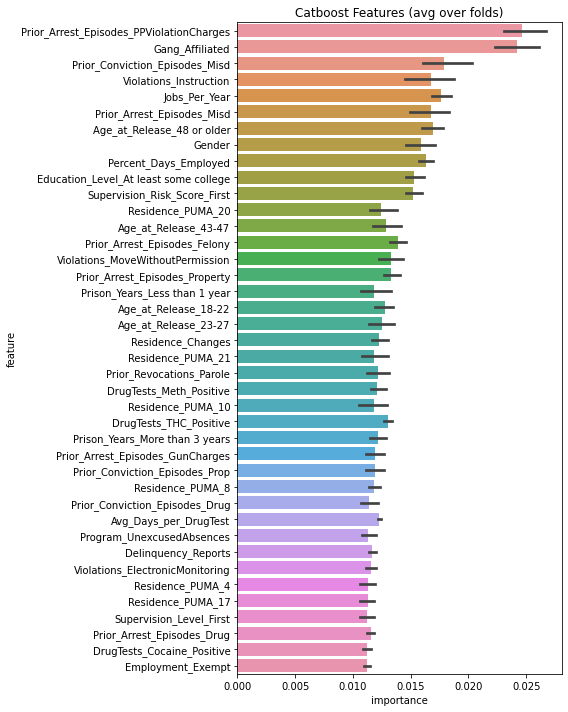

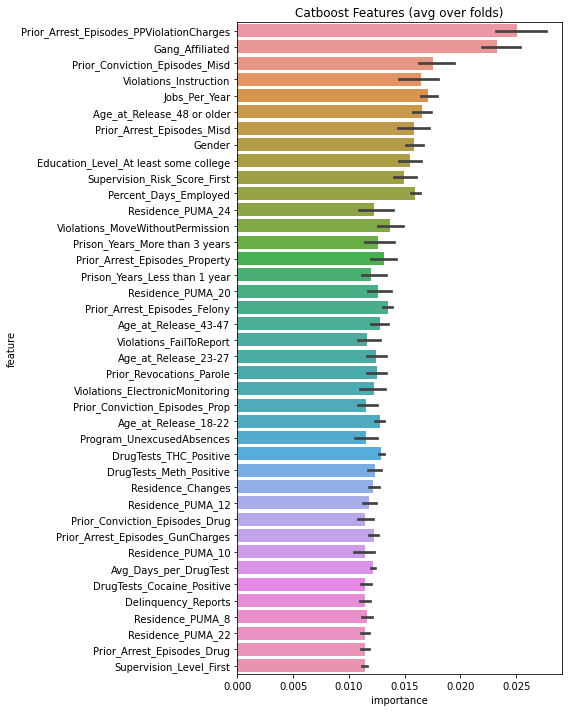

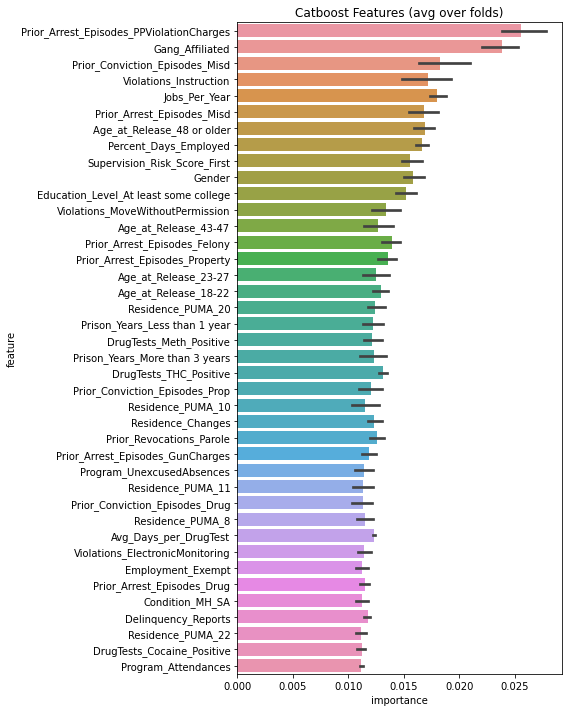

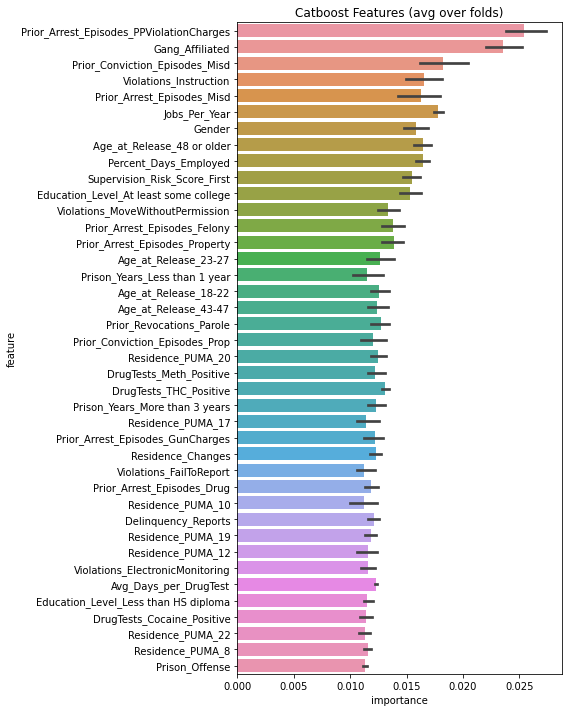

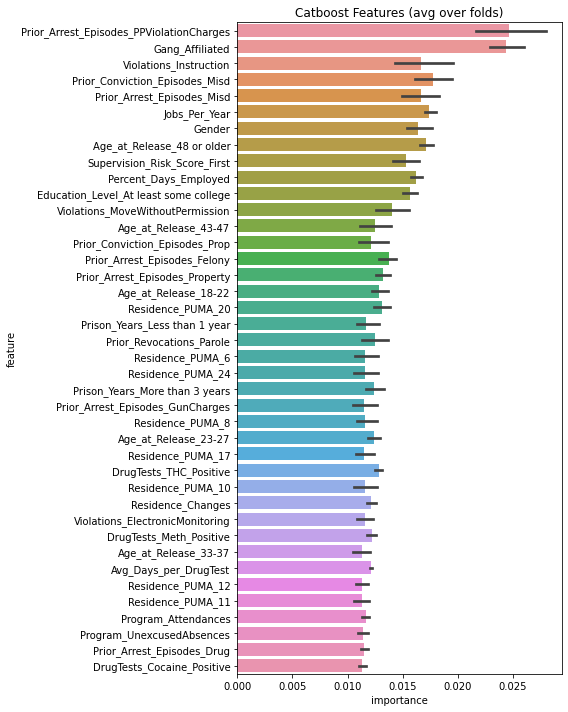

In [116]:
pred_5, oof_preds_5 = kfold_xgboost(train, 5, top_5_params)
pred_4, oof_preds_4 = kfold_xgboost(train, 5, top_4_params)
pred_3, oof_preds_3 = kfold_xgboost(train, 5, top_3_params)
pred_2, oof_preds_2 = kfold_xgboost(train, 5, top_2_params)
pred_1, oof_preds_1 = kfold_xgboost(train, 5, top_1_params)

In [117]:
xgb_train = pd.DataFrame(data={
    "xgb_1": oof_preds_1.tolist(),
    "xgb_2": oof_preds_2.tolist(),
    "xgb_3": oof_preds_3.tolist(),
    "xgb_4": oof_preds_4.tolist(),
    "xgb_5": oof_preds_5.tolist(),
})
xgb_test = pd.DataFrame(data={
    "xgb_1": pred_1.tolist(),
    "xgb_2": pred_2.tolist(),
    "xgb_3": pred_3.tolist(),
    "xgb_4": pred_4.tolist(),
    "xgb_5": pred_5.tolist(),
})

In [118]:
xgb_train.to_csv('xgb_train.csv', index = False)
xgb_test.to_csv('xgb_test.csv', index = False)